In [1]:
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 40
batch_size = 4
display_step = 1
shuffle = True
num_classes = 4

In [2]:
# 加载vgg19预训练模型
model = models.vgg19(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, num_classes))

In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=10) for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [5]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = []  # 训练集loss
acc_train = []  # 训练集正确率
loss_val = []  # 验证集loss
acc_val = []  # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, num_classes):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'validation' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/params_vgg19.pth')
            best_matrix = copy.deepcopy(matrix)
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

Epoch [1/40]:
	train 1-1: Loss: 0.3460 Acc: 50.0000%
	train 1-2: Loss: 0.3444 Acc: 50.0000%
	train 1-3: Loss: 0.3436 Acc: 25.0000%
	train 1-4: Loss: 0.3477 Acc: 0.0000%
	train 1-5: Loss: 0.3410 Acc: 50.0000%
	train 1-6: Loss: 0.3462 Acc: 25.0000%
	train 1-7: Loss: 0.3475 Acc: 0.0000%
	train 1-8: Loss: 0.3503 Acc: 0.0000%
	train 1-9: Loss: 0.3487 Acc: 0.0000%
	train 1-10: Loss: 0.3424 Acc: 50.0000%
	train 1-11: Loss: 0.3535 Acc: 0.0000%
	train 1-12: Loss: 0.3439 Acc: 25.0000%
	train 1-13: Loss: 0.3522 Acc: 0.0000%
	train 1-14: Loss: 0.3541 Acc: 0.0000%
	train 1-15: Loss: 0.3439 Acc: 50.0000%
	train 1-16: Loss: 0.3506 Acc: 0.0000%
	train 1-17: Loss: 0.3458 Acc: 0.0000%
	train 1-18: Loss: 0.3395 Acc: 75.0000%
	train 1-19: Loss: 0.3524 Acc: 0.0000%
	train 1-20: Loss: 0.3516 Acc: 25.0000%
	train 1-21: Loss: 0.3520 Acc: 0.0000%
	train 1-22: Loss: 0.3489 Acc: 0.0000%
	train 1-23: Loss: 0.3389 Acc: 50.0000%
	train 1-24: Loss: 0.3547 Acc: 0.0000%
	train 1-25: Loss: 0.3454 Acc: 25.0000%
	train 1

	train 1-206: Loss: 0.3196 Acc: 50.0000%
	train 1-207: Loss: 0.3505 Acc: 25.0000%
	train 1-208: Loss: 0.3621 Acc: 0.0000%
	train 1-209: Loss: 0.3311 Acc: 50.0000%
	train 1-210: Loss: 0.3466 Acc: 0.0000%
	train 1-211: Loss: 0.3592 Acc: 0.0000%
	train 1-212: Loss: 0.3637 Acc: 0.0000%
	train 1-213: Loss: 0.3334 Acc: 25.0000%
	train 1-214: Loss: 0.3443 Acc: 25.0000%
	train 1-215: Loss: 0.3386 Acc: 25.0000%
	train 1-216: Loss: 0.3300 Acc: 50.0000%
	train 1-217: Loss: 0.3354 Acc: 25.0000%
	train 1-218: Loss: 0.3433 Acc: 25.0000%
	train 1-219: Loss: 0.3387 Acc: 25.0000%
	train 1-220: Loss: 0.3544 Acc: 0.0000%
	train 1-221: Loss: 0.3390 Acc: 75.0000%
	train 1-222: Loss: 0.3441 Acc: 25.0000%
	train 1-223: Loss: 0.3525 Acc: 0.0000%
	train 1-224: Loss: 0.3479 Acc: 0.0000%
	train 1-225: Loss: 0.3418 Acc: 0.0000%
	train 1-226: Loss: 0.3383 Acc: 25.0000%
	train 1-227: Loss: 0.3437 Acc: 50.0000%
	train 1-228: Loss: 0.3362 Acc: 25.0000%
	train 1-229: Loss: 0.3519 Acc: 25.0000%
	train 1-230: Loss: 0.32

	train 2-48: Loss: 0.2929 Acc: 25.0000%
	train 2-49: Loss: 0.2438 Acc: 50.0000%
	train 2-50: Loss: 0.3076 Acc: 25.0000%
	train 2-51: Loss: 0.2827 Acc: 50.0000%
	train 2-52: Loss: 0.2571 Acc: 75.0000%
	train 2-53: Loss: 0.3387 Acc: 25.0000%
	train 2-54: Loss: 0.2988 Acc: 25.0000%
	train 2-55: Loss: 0.2848 Acc: 25.0000%
	train 2-56: Loss: 0.2249 Acc: 75.0000%
	train 2-57: Loss: 0.3492 Acc: 0.0000%
	train 2-58: Loss: 0.3058 Acc: 50.0000%
	train 2-59: Loss: 0.3082 Acc: 50.0000%
	train 2-60: Loss: 0.3706 Acc: 0.0000%
	train 2-61: Loss: 0.3355 Acc: 75.0000%
	train 2-62: Loss: 0.3216 Acc: 25.0000%
	train 2-63: Loss: 0.3177 Acc: 50.0000%
	train 2-64: Loss: 0.3400 Acc: 50.0000%
	train 2-65: Loss: 0.3171 Acc: 100.0000%
	train 2-66: Loss: 0.3241 Acc: 50.0000%
	train 2-67: Loss: 0.3370 Acc: 50.0000%
	train 2-68: Loss: 0.3095 Acc: 100.0000%
	train 2-69: Loss: 0.3124 Acc: 50.0000%
	train 2-70: Loss: 0.3152 Acc: 25.0000%
	train 2-71: Loss: 0.3109 Acc: 25.0000%
	train 2-72: Loss: 0.2671 Acc: 25.0000%


	validation 2-9: Loss: 0.2840 Acc: 75.0000%
	validation 2-10: Loss: 0.3495 Acc: 25.0000%
	validation 2-11: Loss: 0.1872 Acc: 75.0000%
	validation 2-12: Loss: 0.2960 Acc: 50.0000%
	validation 2-13: Loss: 0.2432 Acc: 0.0000%
	validation 2-14: Loss: 0.1555 Acc: 75.0000%
	validation 2-15: Loss: 0.1645 Acc: 75.0000%
	validation 2-16: Loss: 0.2364 Acc: 50.0000%
	validation 2-17: Loss: 0.2371 Acc: 75.0000%
	validation 2-18: Loss: 0.2150 Acc: 75.0000%
	validation 2-19: Loss: 0.2305 Acc: 25.0000%
	validation 2-20: Loss: 0.2815 Acc: 25.0000%
	validation 2-21: Loss: 0.3001 Acc: 75.0000%
	validation 2-22: Loss: 0.3034 Acc: 75.0000%
	validation 2-23: Loss: 0.2243 Acc: 50.0000%
	validation 2-24: Loss: 0.2140 Acc: 50.0000%
	validation 2-25: Loss: 0.2521 Acc: 50.0000%
	validation 2-26: Loss: 0.1852 Acc: 75.0000%
	validation 2-27: Loss: 0.2312 Acc: 50.0000%
	validation 2-28: Loss: 0.1778 Acc: 50.0000%
	validation 2-29: Loss: 0.2586 Acc: 50.0000%
	validation 2-30: Loss: 0.2456 Acc: 50.0000%
	validation 

	train 3-95: Loss: 0.5477 Acc: 50.0000%
	train 3-96: Loss: 0.3712 Acc: 0.0000%
	train 3-97: Loss: 0.2837 Acc: 75.0000%
	train 3-98: Loss: 0.2457 Acc: 25.0000%
	train 3-99: Loss: 0.3456 Acc: 0.0000%
	train 3-100: Loss: 0.3431 Acc: 25.0000%
	train 3-101: Loss: 0.3533 Acc: 50.0000%
	train 3-102: Loss: 0.3137 Acc: 75.0000%
	train 3-103: Loss: 0.3396 Acc: 50.0000%
	train 3-104: Loss: 0.3941 Acc: 25.0000%
	train 3-105: Loss: 0.3202 Acc: 0.0000%
	train 3-106: Loss: 0.3939 Acc: 25.0000%
	train 3-107: Loss: 0.3557 Acc: 25.0000%
	train 3-108: Loss: 0.2867 Acc: 100.0000%
	train 3-109: Loss: 0.3590 Acc: 0.0000%
	train 3-110: Loss: 0.3364 Acc: 0.0000%
	train 3-111: Loss: 0.3545 Acc: 25.0000%
	train 3-112: Loss: 0.3303 Acc: 50.0000%
	train 3-113: Loss: 0.3317 Acc: 25.0000%
	train 3-114: Loss: 0.3508 Acc: 50.0000%
	train 3-115: Loss: 0.3548 Acc: 25.0000%
	train 3-116: Loss: 0.3926 Acc: 25.0000%
	train 3-117: Loss: 0.3804 Acc: 0.0000%
	train 3-118: Loss: 0.3775 Acc: 25.0000%
	train 3-119: Loss: 0.4152

	validation 3-51: Loss: 0.3223 Acc: 75.0000%
	validation 3-52: Loss: 0.3606 Acc: 50.0000%
	validation 3-53: Loss: 0.3437 Acc: 50.0000%
	validation 3-54: Loss: 0.3516 Acc: 0.0000%
	validation 3-55: Loss: 0.3754 Acc: 25.0000%
	validation 3-56: Loss: 0.3290 Acc: 0.0000%
	validation 3-57: Loss: 0.3437 Acc: 0.0000%
	validation 3-58: Loss: 0.3768 Acc: 25.0000%
	validation 3-59: Loss: 0.3506 Acc: 0.0000%
	validation 3-60: Loss: 0.3498 Acc: 25.0000%
	validation 3-61: Loss: 0.3307 Acc: 25.0000%
	validation 3-62: Loss: 0.3281 Acc: 25.0000%
	validation 3-63: Loss: 0.3460 Acc: 25.0000%
	validation 3-64: Loss: 0.3593 Acc: 25.0000%
	validation 3-65: Loss: 0.3324 Acc: 25.0000%
	validation 3-66: Loss: 0.3431 Acc: 50.0000%
	validation 3-67: Loss: 0.3619 Acc: 25.0000%
	validation 3-68: Loss: 0.3288 Acc: 50.0000%
	validation 3-69: Loss: 0.3307 Acc: 0.0000%
	validation 3-70: Loss: 0.3671 Acc: 0.0000%
	validation 3-71: Loss: 0.3478 Acc: 25.0000%
	validation 3-72: Loss: 0.3255 Acc: 50.0000%
	validation 3-73

	train 4-141: Loss: 0.3166 Acc: 75.0000%
	train 4-142: Loss: 0.3156 Acc: 25.0000%
	train 4-143: Loss: 0.3281 Acc: 50.0000%
	train 4-144: Loss: 0.3026 Acc: 25.0000%
	train 4-145: Loss: 0.3019 Acc: 25.0000%
	train 4-146: Loss: 0.3093 Acc: 0.0000%
	train 4-147: Loss: 0.3320 Acc: 0.0000%
	train 4-148: Loss: 0.2855 Acc: 50.0000%
	train 4-149: Loss: 0.2323 Acc: 100.0000%
	train 4-150: Loss: 0.2585 Acc: 50.0000%
	train 4-151: Loss: 0.3097 Acc: 75.0000%
	train 4-152: Loss: 0.2881 Acc: 50.0000%
	train 4-153: Loss: 0.2393 Acc: 100.0000%
	train 4-154: Loss: 0.2014 Acc: 75.0000%
	train 4-155: Loss: 0.2815 Acc: 50.0000%
	train 4-156: Loss: 0.2797 Acc: 75.0000%
	train 4-157: Loss: 0.1826 Acc: 75.0000%
	train 4-158: Loss: 0.3124 Acc: 25.0000%
	train 4-159: Loss: 0.2327 Acc: 50.0000%
	train 4-160: Loss: 0.3083 Acc: 75.0000%
	train 4-161: Loss: 0.2764 Acc: 75.0000%
	train 4-162: Loss: 0.2427 Acc: 50.0000%
	train 4-163: Loss: 0.3133 Acc: 0.0000%
	train 4-164: Loss: 0.2912 Acc: 25.0000%
	train 4-165: Los

	validation 4-89: Loss: 0.2571 Acc: 75.0000%
	validation 4-90: Loss: 0.3035 Acc: 50.0000%
	validation 4-91: Loss: 0.3854 Acc: 0.0000%
	validation 4-92: Loss: 0.3464 Acc: 50.0000%
	validation 4-93: Loss: 0.2920 Acc: 25.0000%
	validation 4-94: Loss: 0.3237 Acc: 25.0000%
	validation 4-95: Loss: 0.3320 Acc: 0.0000%
	validation 4-96: Loss: 0.2899 Acc: 50.0000%
	validation 4-97: Loss: 0.2480 Acc: 50.0000%
	validation 4-98: Loss: 0.3126 Acc: 50.0000%
	validation 4-99: Loss: 0.3790 Acc: 25.0000%
	validation 4-100: Loss: 0.3516 Acc: 0.0000%
	validation 4-101: Loss: 0.2977 Acc: 50.0000%
	validation 4-102: Loss: 0.3147 Acc: 50.0000%
	validation 4-103: Loss: 0.3671 Acc: 25.0000%
	validation 4-104: Loss: 0.3799 Acc: 0.0000%
	validation 4-105: Loss: 0.3139 Acc: 75.0000%
	train Loss: 0.3067 Acc: 39.4898%
	validation Loss: 0.3155 Acc: 40.2381%
Time passed 0h 2m 56s
--------------------
Epoch [5/40]:
	train 5-1: Loss: 0.2869 Acc: 50.0000%
	train 5-2: Loss: 0.3488 Acc: 0.0000%
	train 5-3: Loss: 0.3537 A

	train 5-183: Loss: 0.3264 Acc: 50.0000%
	train 5-184: Loss: 0.2327 Acc: 25.0000%
	train 5-185: Loss: 0.2268 Acc: 75.0000%
	train 5-186: Loss: 0.1982 Acc: 50.0000%
	train 5-187: Loss: 0.2715 Acc: 25.0000%
	train 5-188: Loss: 0.2636 Acc: 50.0000%
	train 5-189: Loss: 0.1344 Acc: 75.0000%
	train 5-190: Loss: 0.1950 Acc: 75.0000%
	train 5-191: Loss: 0.1679 Acc: 100.0000%
	train 5-192: Loss: 0.3263 Acc: 25.0000%
	train 5-193: Loss: 0.2358 Acc: 50.0000%
	train 5-194: Loss: 0.2278 Acc: 50.0000%
	train 5-195: Loss: 0.4456 Acc: 25.0000%
	train 5-196: Loss: 0.1088 Acc: 75.0000%
	train 5-197: Loss: 0.1576 Acc: 75.0000%
	train 5-198: Loss: 0.2637 Acc: 50.0000%
	train 5-199: Loss: 0.2078 Acc: 50.0000%
	train 5-200: Loss: 0.1655 Acc: 75.0000%
	train 5-201: Loss: 0.2095 Acc: 100.0000%
	train 5-202: Loss: 0.2601 Acc: 50.0000%
	train 5-203: Loss: 0.2901 Acc: 75.0000%
	train 5-204: Loss: 0.2723 Acc: 0.0000%
	train 5-205: Loss: 0.1962 Acc: 50.0000%
	train 5-206: Loss: 0.3032 Acc: 50.0000%
	train 5-207: L

	train 6-21: Loss: 0.2429 Acc: 50.0000%
	train 6-22: Loss: 0.2828 Acc: 50.0000%
	train 6-23: Loss: 0.2681 Acc: 50.0000%
	train 6-24: Loss: 0.2291 Acc: 75.0000%
	train 6-25: Loss: 0.3255 Acc: 75.0000%
	train 6-26: Loss: 0.2973 Acc: 75.0000%
	train 6-27: Loss: 0.2062 Acc: 50.0000%
	train 6-28: Loss: 0.2036 Acc: 75.0000%
	train 6-29: Loss: 0.2491 Acc: 75.0000%
	train 6-30: Loss: 0.3084 Acc: 50.0000%
	train 6-31: Loss: 0.2123 Acc: 75.0000%
	train 6-32: Loss: 0.1007 Acc: 100.0000%
	train 6-33: Loss: 0.2468 Acc: 50.0000%
	train 6-34: Loss: 0.0753 Acc: 75.0000%
	train 6-35: Loss: 0.3259 Acc: 0.0000%
	train 6-36: Loss: 0.2734 Acc: 50.0000%
	train 6-37: Loss: 0.1100 Acc: 100.0000%
	train 6-38: Loss: 0.1960 Acc: 50.0000%
	train 6-39: Loss: 0.2497 Acc: 50.0000%
	train 6-40: Loss: 0.1744 Acc: 50.0000%
	train 6-41: Loss: 0.2157 Acc: 75.0000%
	train 6-42: Loss: 0.3519 Acc: 25.0000%
	train 6-43: Loss: 0.2557 Acc: 50.0000%
	train 6-44: Loss: 0.1768 Acc: 100.0000%
	train 6-45: Loss: 0.2032 Acc: 75.0000

	train 6-224: Loss: 0.3795 Acc: 50.0000%
	train 6-225: Loss: 0.1572 Acc: 100.0000%
	train 6-226: Loss: 0.2780 Acc: 50.0000%
	train 6-227: Loss: 0.2705 Acc: 50.0000%
	train 6-228: Loss: 0.3936 Acc: 0.0000%
	train 6-229: Loss: 0.4072 Acc: 0.0000%
	train 6-230: Loss: 0.4207 Acc: 0.0000%
	train 6-231: Loss: 0.3528 Acc: 25.0000%
	train 6-232: Loss: 0.3603 Acc: 50.0000%
	train 6-233: Loss: 0.2938 Acc: 25.0000%
	train 6-234: Loss: 0.2607 Acc: 25.0000%
	train 6-235: Loss: 0.1907 Acc: 50.0000%
	train 6-236: Loss: 0.2222 Acc: 75.0000%
	train 6-237: Loss: 0.2936 Acc: 50.0000%
	train 6-238: Loss: 0.1369 Acc: 100.0000%
	train 6-239: Loss: 0.2398 Acc: 75.0000%
	train 6-240: Loss: 0.3449 Acc: 25.0000%
	train 6-241: Loss: 0.2061 Acc: 50.0000%
	train 6-242: Loss: 0.2296 Acc: 25.0000%
	train 6-243: Loss: 0.2537 Acc: 100.0000%
	train 6-244: Loss: 0.2651 Acc: 50.0000%
	train 6-245: Loss: 0.2612 Acc: 50.0000%
	validation 6-1: Loss: 0.2611 Acc: 50.0000%
	validation 6-2: Loss: 0.2684 Acc: 25.0000%
	validatio

	train 7-63: Loss: 0.2176 Acc: 75.0000%
	train 7-64: Loss: 0.1644 Acc: 50.0000%
	train 7-65: Loss: 0.1778 Acc: 100.0000%
	train 7-66: Loss: 0.2231 Acc: 75.0000%
	train 7-67: Loss: 0.2409 Acc: 50.0000%
	train 7-68: Loss: 0.2303 Acc: 75.0000%
	train 7-69: Loss: 0.1186 Acc: 100.0000%
	train 7-70: Loss: 0.1809 Acc: 75.0000%
	train 7-71: Loss: 0.3038 Acc: 75.0000%
	train 7-72: Loss: 0.2425 Acc: 50.0000%
	train 7-73: Loss: 0.2067 Acc: 50.0000%
	train 7-74: Loss: 0.2793 Acc: 50.0000%
	train 7-75: Loss: 0.1943 Acc: 75.0000%
	train 7-76: Loss: 0.2213 Acc: 75.0000%
	train 7-77: Loss: 0.2511 Acc: 0.0000%
	train 7-78: Loss: 0.2257 Acc: 50.0000%
	train 7-79: Loss: 0.2185 Acc: 50.0000%
	train 7-80: Loss: 0.1034 Acc: 75.0000%
	train 7-81: Loss: 0.0522 Acc: 100.0000%
	train 7-82: Loss: 0.2150 Acc: 50.0000%
	train 7-83: Loss: 0.1735 Acc: 50.0000%
	train 7-84: Loss: 0.1408 Acc: 100.0000%
	train 7-85: Loss: 0.1206 Acc: 100.0000%
	train 7-86: Loss: 0.1120 Acc: 100.0000%
	train 7-87: Loss: 0.1834 Acc: 75.0

	validation 7-18: Loss: 0.1820 Acc: 75.0000%
	validation 7-19: Loss: 0.1116 Acc: 100.0000%
	validation 7-20: Loss: 0.2500 Acc: 50.0000%
	validation 7-21: Loss: 0.2996 Acc: 50.0000%
	validation 7-22: Loss: 0.1031 Acc: 75.0000%
	validation 7-23: Loss: 0.2305 Acc: 75.0000%
	validation 7-24: Loss: 0.4199 Acc: 25.0000%
	validation 7-25: Loss: 0.1537 Acc: 50.0000%
	validation 7-26: Loss: 0.2410 Acc: 50.0000%
	validation 7-27: Loss: 0.2898 Acc: 25.0000%
	validation 7-28: Loss: 0.1656 Acc: 50.0000%
	validation 7-29: Loss: 0.1751 Acc: 50.0000%
	validation 7-30: Loss: 0.1795 Acc: 75.0000%
	validation 7-31: Loss: 0.1865 Acc: 75.0000%
	validation 7-32: Loss: 0.2111 Acc: 50.0000%
	validation 7-33: Loss: 0.1846 Acc: 75.0000%
	validation 7-34: Loss: 0.2684 Acc: 0.0000%
	validation 7-35: Loss: 0.3201 Acc: 50.0000%
	validation 7-36: Loss: 0.1886 Acc: 75.0000%
	validation 7-37: Loss: 0.2272 Acc: 25.0000%
	validation 7-38: Loss: 0.2413 Acc: 25.0000%
	validation 7-39: Loss: 0.2874 Acc: 0.0000%
	validation

	train 8-104: Loss: 0.2806 Acc: 25.0000%
	train 8-105: Loss: 0.4157 Acc: 0.0000%
	train 8-106: Loss: 0.2630 Acc: 50.0000%
	train 8-107: Loss: 0.2842 Acc: 50.0000%
	train 8-108: Loss: 0.3456 Acc: 25.0000%
	train 8-109: Loss: 0.4303 Acc: 25.0000%
	train 8-110: Loss: 0.2343 Acc: 75.0000%
	train 8-111: Loss: 0.3647 Acc: 25.0000%
	train 8-112: Loss: 0.2209 Acc: 50.0000%
	train 8-113: Loss: 0.1727 Acc: 100.0000%
	train 8-114: Loss: 0.2219 Acc: 75.0000%
	train 8-115: Loss: 0.2447 Acc: 50.0000%
	train 8-116: Loss: 0.3417 Acc: 25.0000%
	train 8-117: Loss: 0.4257 Acc: 50.0000%
	train 8-118: Loss: 0.2710 Acc: 25.0000%
	train 8-119: Loss: 0.2543 Acc: 25.0000%
	train 8-120: Loss: 0.1815 Acc: 50.0000%
	train 8-121: Loss: 0.2344 Acc: 50.0000%
	train 8-122: Loss: 0.2882 Acc: 25.0000%
	train 8-123: Loss: 0.2511 Acc: 50.0000%
	train 8-124: Loss: 0.2928 Acc: 50.0000%
	train 8-125: Loss: 0.1900 Acc: 100.0000%
	train 8-126: Loss: 0.3840 Acc: 25.0000%
	train 8-127: Loss: 0.4706 Acc: 25.0000%
	train 8-128: L

	validation 8-54: Loss: 0.2241 Acc: 50.0000%
	validation 8-55: Loss: 0.3030 Acc: 50.0000%
	validation 8-56: Loss: 0.0908 Acc: 75.0000%
	validation 8-57: Loss: 0.1949 Acc: 50.0000%
	validation 8-58: Loss: 0.1835 Acc: 50.0000%
	validation 8-59: Loss: 0.2252 Acc: 75.0000%
	validation 8-60: Loss: 0.1570 Acc: 75.0000%
	validation 8-61: Loss: 0.1769 Acc: 75.0000%
	validation 8-62: Loss: 0.1843 Acc: 50.0000%
	validation 8-63: Loss: 0.2774 Acc: 75.0000%
	validation 8-64: Loss: 0.2552 Acc: 25.0000%
	validation 8-65: Loss: 0.2271 Acc: 50.0000%
	validation 8-66: Loss: 0.2061 Acc: 50.0000%
	validation 8-67: Loss: 0.2318 Acc: 50.0000%
	validation 8-68: Loss: 0.1206 Acc: 100.0000%
	validation 8-69: Loss: 0.1793 Acc: 50.0000%
	validation 8-70: Loss: 0.1305 Acc: 50.0000%
	validation 8-71: Loss: 0.0554 Acc: 75.0000%
	validation 8-72: Loss: 0.2324 Acc: 25.0000%
	validation 8-73: Loss: 0.3203 Acc: 50.0000%
	validation 8-74: Loss: 0.1877 Acc: 50.0000%
	validation 8-75: Loss: 0.2118 Acc: 50.0000%
	validati

	train 9-144: Loss: 0.4540 Acc: 0.0000%
	train 9-145: Loss: 0.2902 Acc: 50.0000%
	train 9-146: Loss: 0.4032 Acc: 50.0000%
	train 9-147: Loss: 0.4117 Acc: 0.0000%
	train 9-148: Loss: 0.3407 Acc: 25.0000%
	train 9-149: Loss: 0.3848 Acc: 25.0000%
	train 9-150: Loss: 0.3720 Acc: 0.0000%
	train 9-151: Loss: 0.3117 Acc: 50.0000%
	train 9-152: Loss: 0.3438 Acc: 50.0000%
	train 9-153: Loss: 0.3183 Acc: 75.0000%
	train 9-154: Loss: 0.3030 Acc: 50.0000%
	train 9-155: Loss: 0.3436 Acc: 25.0000%
	train 9-156: Loss: 0.2933 Acc: 50.0000%
	train 9-157: Loss: 0.3163 Acc: 75.0000%
	train 9-158: Loss: 0.2442 Acc: 100.0000%
	train 9-159: Loss: 0.2737 Acc: 50.0000%
	train 9-160: Loss: 0.4388 Acc: 0.0000%
	train 9-161: Loss: 0.4162 Acc: 0.0000%
	train 9-162: Loss: 0.5075 Acc: 0.0000%
	train 9-163: Loss: 0.3910 Acc: 0.0000%
	train 9-164: Loss: 0.3855 Acc: 25.0000%
	train 9-165: Loss: 0.3557 Acc: 25.0000%
	train 9-166: Loss: 0.4598 Acc: 0.0000%
	train 9-167: Loss: 0.2494 Acc: 50.0000%
	train 9-168: Loss: 0.3

	validation 9-91: Loss: 0.2840 Acc: 50.0000%
	validation 9-92: Loss: 0.2672 Acc: 75.0000%
	validation 9-93: Loss: 0.2775 Acc: 25.0000%
	validation 9-94: Loss: 0.2075 Acc: 75.0000%
	validation 9-95: Loss: 0.2719 Acc: 25.0000%
	validation 9-96: Loss: 0.1909 Acc: 75.0000%
	validation 9-97: Loss: 0.2624 Acc: 50.0000%
	validation 9-98: Loss: 0.2522 Acc: 50.0000%
	validation 9-99: Loss: 0.2841 Acc: 50.0000%
	validation 9-100: Loss: 0.2915 Acc: 50.0000%
	validation 9-101: Loss: 0.2491 Acc: 50.0000%
	validation 9-102: Loss: 0.2335 Acc: 75.0000%
	validation 9-103: Loss: 0.2330 Acc: 75.0000%
	validation 9-104: Loss: 0.2268 Acc: 75.0000%
	validation 9-105: Loss: 0.2246 Acc: 50.0000%
	train Loss: 0.2902 Acc: 43.4694%
	validation Loss: 0.2530 Acc: 55.0000%
Time passed 0h 7m 6s
--------------------
Epoch [10/40]:
	train 10-1: Loss: 0.2249 Acc: 25.0000%
	train 10-2: Loss: 0.3296 Acc: 0.0000%
	train 10-3: Loss: 0.2607 Acc: 75.0000%
	train 10-4: Loss: 0.2501 Acc: 50.0000%
	train 10-5: Loss: 0.3089 Acc:

	train 10-180: Loss: 0.0573 Acc: 100.0000%
	train 10-181: Loss: 0.0571 Acc: 75.0000%
	train 10-182: Loss: 0.1572 Acc: 100.0000%
	train 10-183: Loss: 0.1348 Acc: 75.0000%
	train 10-184: Loss: 0.2103 Acc: 50.0000%
	train 10-185: Loss: 0.0958 Acc: 75.0000%
	train 10-186: Loss: 0.2117 Acc: 75.0000%
	train 10-187: Loss: 0.1306 Acc: 75.0000%
	train 10-188: Loss: 0.1268 Acc: 75.0000%
	train 10-189: Loss: 0.0001 Acc: 100.0000%
	train 10-190: Loss: 0.2620 Acc: 50.0000%
	train 10-191: Loss: 0.2161 Acc: 50.0000%
	train 10-192: Loss: 0.2184 Acc: 50.0000%
	train 10-193: Loss: 0.1277 Acc: 75.0000%
	train 10-194: Loss: 0.1018 Acc: 100.0000%
	train 10-195: Loss: 0.1781 Acc: 75.0000%
	train 10-196: Loss: 0.1353 Acc: 50.0000%
	train 10-197: Loss: 0.2454 Acc: 50.0000%
	train 10-198: Loss: 0.1398 Acc: 50.0000%
	train 10-199: Loss: 0.2648 Acc: 75.0000%
	train 10-200: Loss: 0.1105 Acc: 75.0000%
	train 10-201: Loss: 0.1051 Acc: 100.0000%
	train 10-202: Loss: 0.1644 Acc: 100.0000%
	train 10-203: Loss: 0.1580 

	train 11-13: Loss: 0.3212 Acc: 75.0000%
	train 11-14: Loss: 0.1695 Acc: 75.0000%
	train 11-15: Loss: 0.1651 Acc: 50.0000%
	train 11-16: Loss: 0.4128 Acc: 25.0000%
	train 11-17: Loss: 0.3255 Acc: 50.0000%
	train 11-18: Loss: 0.3011 Acc: 50.0000%
	train 11-19: Loss: 0.1599 Acc: 75.0000%
	train 11-20: Loss: 0.3337 Acc: 25.0000%
	train 11-21: Loss: 0.3735 Acc: 25.0000%
	train 11-22: Loss: 0.2105 Acc: 75.0000%
	train 11-23: Loss: 0.1804 Acc: 100.0000%
	train 11-24: Loss: 0.2753 Acc: 50.0000%
	train 11-25: Loss: 0.2073 Acc: 75.0000%
	train 11-26: Loss: 0.2670 Acc: 0.0000%
	train 11-27: Loss: 0.2221 Acc: 50.0000%
	train 11-28: Loss: 0.2637 Acc: 75.0000%
	train 11-29: Loss: 0.2016 Acc: 50.0000%
	train 11-30: Loss: 0.2989 Acc: 25.0000%
	train 11-31: Loss: 0.3688 Acc: 25.0000%
	train 11-32: Loss: 0.2559 Acc: 25.0000%
	train 11-33: Loss: 0.1504 Acc: 75.0000%
	train 11-34: Loss: 0.2195 Acc: 50.0000%
	train 11-35: Loss: 0.3936 Acc: 25.0000%
	train 11-36: Loss: 0.5432 Acc: 25.0000%
	train 11-37: Lo

	train 11-210: Loss: 0.1134 Acc: 75.0000%
	train 11-211: Loss: 0.0548 Acc: 75.0000%
	train 11-212: Loss: 0.0024 Acc: 100.0000%
	train 11-213: Loss: 0.2483 Acc: 75.0000%
	train 11-214: Loss: 0.4761 Acc: 50.0000%
	train 11-215: Loss: 0.1596 Acc: 75.0000%
	train 11-216: Loss: 0.1060 Acc: 50.0000%
	train 11-217: Loss: 0.1543 Acc: 50.0000%
	train 11-218: Loss: 0.1573 Acc: 25.0000%
	train 11-219: Loss: 0.1794 Acc: 75.0000%
	train 11-220: Loss: 0.1546 Acc: 50.0000%
	train 11-221: Loss: 0.2033 Acc: 75.0000%
	train 11-222: Loss: 0.2332 Acc: 75.0000%
	train 11-223: Loss: 0.0950 Acc: 100.0000%
	train 11-224: Loss: 0.2087 Acc: 50.0000%
	train 11-225: Loss: 0.1035 Acc: 50.0000%
	train 11-226: Loss: 0.1674 Acc: 75.0000%
	train 11-227: Loss: 0.2078 Acc: 50.0000%
	train 11-228: Loss: 0.1565 Acc: 25.0000%
	train 11-229: Loss: 0.0009 Acc: 100.0000%
	train 11-230: Loss: 0.2056 Acc: 75.0000%
	train 11-231: Loss: 0.1437 Acc: 75.0000%
	train 11-232: Loss: 0.1580 Acc: 75.0000%
	train 11-233: Loss: 0.1584 Acc

	train 12-43: Loss: 0.1060 Acc: 50.0000%
	train 12-44: Loss: 0.2915 Acc: 50.0000%
	train 12-45: Loss: 0.1577 Acc: 50.0000%
	train 12-46: Loss: 0.2043 Acc: 50.0000%
	train 12-47: Loss: 0.1991 Acc: 75.0000%
	train 12-48: Loss: 0.2203 Acc: 75.0000%
	train 12-49: Loss: 0.1514 Acc: 50.0000%
	train 12-50: Loss: 0.2009 Acc: 50.0000%
	train 12-51: Loss: 0.3784 Acc: 25.0000%
	train 12-52: Loss: 0.1428 Acc: 75.0000%
	train 12-53: Loss: 0.1411 Acc: 75.0000%
	train 12-54: Loss: 0.1523 Acc: 75.0000%
	train 12-55: Loss: 0.2024 Acc: 25.0000%
	train 12-56: Loss: 0.1633 Acc: 75.0000%
	train 12-57: Loss: 0.0507 Acc: 100.0000%
	train 12-58: Loss: 0.1802 Acc: 25.0000%
	train 12-59: Loss: 0.1379 Acc: 75.0000%
	train 12-60: Loss: 0.1097 Acc: 75.0000%
	train 12-61: Loss: 0.0491 Acc: 100.0000%
	train 12-62: Loss: 0.0000 Acc: 100.0000%
	train 12-63: Loss: 0.1517 Acc: 50.0000%
	train 12-64: Loss: 0.2233 Acc: 25.0000%
	train 12-65: Loss: 0.0626 Acc: 100.0000%
	train 12-66: Loss: 0.2874 Acc: 50.0000%
	train 12-67

	train 12-240: Loss: 0.2670 Acc: 25.0000%
	train 12-241: Loss: 0.1374 Acc: 75.0000%
	train 12-242: Loss: 0.2389 Acc: 50.0000%
	train 12-243: Loss: 0.1538 Acc: 75.0000%
	train 12-244: Loss: 0.2726 Acc: 25.0000%
	train 12-245: Loss: 0.2296 Acc: 75.0000%
	validation 12-1: Loss: 0.1955 Acc: 25.0000%
	validation 12-2: Loss: 0.3402 Acc: 50.0000%
	validation 12-3: Loss: 0.1101 Acc: 50.0000%
	validation 12-4: Loss: 0.1962 Acc: 50.0000%
	validation 12-5: Loss: 0.1879 Acc: 50.0000%
	validation 12-6: Loss: 0.2640 Acc: 0.0000%
	validation 12-7: Loss: 0.2037 Acc: 75.0000%
	validation 12-8: Loss: 0.1272 Acc: 75.0000%
	validation 12-9: Loss: 0.1927 Acc: 50.0000%
	validation 12-10: Loss: 0.3112 Acc: 50.0000%
	validation 12-11: Loss: 0.2787 Acc: 25.0000%
	validation 12-12: Loss: 0.1047 Acc: 75.0000%
	validation 12-13: Loss: 0.2326 Acc: 0.0000%
	validation 12-14: Loss: 0.1952 Acc: 75.0000%
	validation 12-15: Loss: 0.2095 Acc: 25.0000%
	validation 12-16: Loss: 0.2364 Acc: 50.0000%
	validation 12-17: Loss

	train 13-75: Loss: 0.2474 Acc: 50.0000%
	train 13-76: Loss: 0.2930 Acc: 50.0000%
	train 13-77: Loss: 0.3093 Acc: 50.0000%
	train 13-78: Loss: 0.3474 Acc: 0.0000%
	train 13-79: Loss: 0.1579 Acc: 75.0000%
	train 13-80: Loss: 0.2214 Acc: 25.0000%
	train 13-81: Loss: 0.1783 Acc: 75.0000%
	train 13-82: Loss: 0.2518 Acc: 25.0000%
	train 13-83: Loss: 0.1314 Acc: 75.0000%
	train 13-84: Loss: 0.1112 Acc: 75.0000%
	train 13-85: Loss: 0.2202 Acc: 50.0000%
	train 13-86: Loss: 0.2078 Acc: 50.0000%
	train 13-87: Loss: 0.2123 Acc: 50.0000%
	train 13-88: Loss: 0.1630 Acc: 75.0000%
	train 13-89: Loss: 0.2258 Acc: 50.0000%
	train 13-90: Loss: 0.2716 Acc: 25.0000%
	train 13-91: Loss: 0.2170 Acc: 50.0000%
	train 13-92: Loss: 0.2310 Acc: 50.0000%
	train 13-93: Loss: 0.1780 Acc: 50.0000%
	train 13-94: Loss: 0.1715 Acc: 75.0000%
	train 13-95: Loss: 0.2503 Acc: 50.0000%
	train 13-96: Loss: 0.0923 Acc: 75.0000%
	train 13-97: Loss: 0.1543 Acc: 50.0000%
	train 13-98: Loss: 0.2361 Acc: 0.0000%
	train 13-99: Loss

	validation 13-25: Loss: 0.0678 Acc: 75.0000%
	validation 13-26: Loss: 0.1733 Acc: 50.0000%
	validation 13-27: Loss: 0.0950 Acc: 100.0000%
	validation 13-28: Loss: 0.1049 Acc: 100.0000%
	validation 13-29: Loss: 0.0626 Acc: 100.0000%
	validation 13-30: Loss: 0.1432 Acc: 75.0000%
	validation 13-31: Loss: 0.0655 Acc: 100.0000%
	validation 13-32: Loss: 0.2363 Acc: 50.0000%
	validation 13-33: Loss: 0.2304 Acc: 75.0000%
	validation 13-34: Loss: 0.1035 Acc: 100.0000%
	validation 13-35: Loss: 0.1260 Acc: 75.0000%
	validation 13-36: Loss: 0.1089 Acc: 100.0000%
	validation 13-37: Loss: 0.1223 Acc: 50.0000%
	validation 13-38: Loss: 0.0947 Acc: 100.0000%
	validation 13-39: Loss: 0.2995 Acc: 50.0000%
	validation 13-40: Loss: 0.1259 Acc: 75.0000%
	validation 13-41: Loss: 0.1500 Acc: 75.0000%
	validation 13-42: Loss: 0.1086 Acc: 100.0000%
	validation 13-43: Loss: 0.2137 Acc: 25.0000%
	validation 13-44: Loss: 0.1745 Acc: 50.0000%
	validation 13-45: Loss: 0.0548 Acc: 100.0000%
	validation 13-46: Loss: 

	train 14-107: Loss: 0.0514 Acc: 100.0000%
	train 14-108: Loss: 0.0020 Acc: 100.0000%
	train 14-109: Loss: 0.1131 Acc: 50.0000%
	train 14-110: Loss: 0.0685 Acc: 75.0000%
	train 14-111: Loss: 0.1339 Acc: 50.0000%
	train 14-112: Loss: 0.1720 Acc: 50.0000%
	train 14-113: Loss: 0.1413 Acc: 75.0000%
	train 14-114: Loss: 0.1422 Acc: 75.0000%
	train 14-115: Loss: 0.2699 Acc: 75.0000%
	train 14-116: Loss: 0.1473 Acc: 50.0000%
	train 14-117: Loss: 0.1469 Acc: 75.0000%
	train 14-118: Loss: 0.3081 Acc: 50.0000%
	train 14-119: Loss: 0.2252 Acc: 75.0000%
	train 14-120: Loss: 0.1434 Acc: 75.0000%
	train 14-121: Loss: 0.2457 Acc: 25.0000%
	train 14-122: Loss: 0.2031 Acc: 50.0000%
	train 14-123: Loss: 0.2410 Acc: 75.0000%
	train 14-124: Loss: 0.1542 Acc: 50.0000%
	train 14-125: Loss: 0.2013 Acc: 75.0000%
	train 14-126: Loss: 0.1476 Acc: 75.0000%
	train 14-127: Loss: 0.2044 Acc: 50.0000%
	train 14-128: Loss: 0.0760 Acc: 100.0000%
	train 14-129: Loss: 0.1688 Acc: 75.0000%
	train 14-130: Loss: 0.2192 Acc

	validation 14-55: Loss: 0.0801 Acc: 100.0000%
	validation 14-56: Loss: 0.1395 Acc: 25.0000%
	validation 14-57: Loss: 0.1883 Acc: 50.0000%
	validation 14-58: Loss: 0.1852 Acc: 75.0000%
	validation 14-59: Loss: 0.1448 Acc: 100.0000%
	validation 14-60: Loss: 0.0650 Acc: 75.0000%
	validation 14-61: Loss: 0.0643 Acc: 75.0000%
	validation 14-62: Loss: 0.1679 Acc: 50.0000%
	validation 14-63: Loss: 0.1531 Acc: 50.0000%
	validation 14-64: Loss: 0.0553 Acc: 100.0000%
	validation 14-65: Loss: 0.1193 Acc: 75.0000%
	validation 14-66: Loss: 0.1859 Acc: 25.0000%
	validation 14-67: Loss: 0.0985 Acc: 75.0000%
	validation 14-68: Loss: 0.0965 Acc: 75.0000%
	validation 14-69: Loss: 0.1385 Acc: 75.0000%
	validation 14-70: Loss: 0.0822 Acc: 100.0000%
	validation 14-71: Loss: 0.1135 Acc: 100.0000%
	validation 14-72: Loss: 0.4754 Acc: 25.0000%
	validation 14-73: Loss: 0.1059 Acc: 75.0000%
	validation 14-74: Loss: 0.0461 Acc: 100.0000%
	validation 14-75: Loss: 0.0936 Acc: 75.0000%
	validation 14-76: Loss: 0.2

	train 15-139: Loss: 0.1656 Acc: 75.0000%
	train 15-140: Loss: 0.2945 Acc: 25.0000%
	train 15-141: Loss: 0.3656 Acc: 75.0000%
	train 15-142: Loss: 0.1601 Acc: 75.0000%
	train 15-143: Loss: 0.0579 Acc: 100.0000%
	train 15-144: Loss: 0.2140 Acc: 25.0000%
	train 15-145: Loss: 0.1968 Acc: 50.0000%
	train 15-146: Loss: 0.2743 Acc: 75.0000%
	train 15-147: Loss: 0.2089 Acc: 50.0000%
	train 15-148: Loss: 0.3003 Acc: 50.0000%
	train 15-149: Loss: 0.2992 Acc: 25.0000%
	train 15-150: Loss: 0.2953 Acc: 25.0000%
	train 15-151: Loss: 0.1532 Acc: 50.0000%
	train 15-152: Loss: 0.3722 Acc: 50.0000%
	train 15-153: Loss: 0.2948 Acc: 25.0000%
	train 15-154: Loss: 0.1021 Acc: 75.0000%
	train 15-155: Loss: 0.2185 Acc: 75.0000%
	train 15-156: Loss: 0.2905 Acc: 50.0000%
	train 15-157: Loss: 0.1669 Acc: 100.0000%
	train 15-158: Loss: 0.0987 Acc: 75.0000%
	train 15-159: Loss: 0.2009 Acc: 75.0000%
	train 15-160: Loss: 0.3436 Acc: 50.0000%
	train 15-161: Loss: 0.1125 Acc: 75.0000%
	train 15-162: Loss: 0.1492 Acc:

	validation 15-83: Loss: 0.1868 Acc: 50.0000%
	validation 15-84: Loss: 0.2330 Acc: 25.0000%
	validation 15-85: Loss: 0.0754 Acc: 100.0000%
	validation 15-86: Loss: 0.1903 Acc: 25.0000%
	validation 15-87: Loss: 0.0970 Acc: 75.0000%
	validation 15-88: Loss: 0.2488 Acc: 50.0000%
	validation 15-89: Loss: 0.1678 Acc: 50.0000%
	validation 15-90: Loss: 0.1442 Acc: 50.0000%
	validation 15-91: Loss: 0.1298 Acc: 100.0000%
	validation 15-92: Loss: 0.2869 Acc: 50.0000%
	validation 15-93: Loss: 0.1996 Acc: 50.0000%
	validation 15-94: Loss: 0.1373 Acc: 75.0000%
	validation 15-95: Loss: 0.2068 Acc: 50.0000%
	validation 15-96: Loss: 0.0764 Acc: 75.0000%
	validation 15-97: Loss: 0.1913 Acc: 75.0000%
	validation 15-98: Loss: 0.5957 Acc: 50.0000%
	validation 15-99: Loss: 0.1503 Acc: 75.0000%
	validation 15-100: Loss: 0.1133 Acc: 100.0000%
	validation 15-101: Loss: 0.1678 Acc: 50.0000%
	validation 15-102: Loss: 0.3586 Acc: 50.0000%
	validation 15-103: Loss: 0.0307 Acc: 100.0000%
	validation 15-104: Loss: 

	train 16-172: Loss: 0.1414 Acc: 75.0000%
	train 16-173: Loss: 0.2282 Acc: 50.0000%
	train 16-174: Loss: 0.4709 Acc: 25.0000%
	train 16-175: Loss: 0.1430 Acc: 75.0000%
	train 16-176: Loss: 0.2650 Acc: 25.0000%
	train 16-177: Loss: 0.0558 Acc: 100.0000%
	train 16-178: Loss: 0.0692 Acc: 75.0000%
	train 16-179: Loss: 0.0583 Acc: 100.0000%
	train 16-180: Loss: 0.1329 Acc: 75.0000%
	train 16-181: Loss: 0.1213 Acc: 75.0000%
	train 16-182: Loss: 0.0707 Acc: 75.0000%
	train 16-183: Loss: 0.1496 Acc: 50.0000%
	train 16-184: Loss: 0.1107 Acc: 75.0000%
	train 16-185: Loss: 0.2384 Acc: 25.0000%
	train 16-186: Loss: 0.1220 Acc: 50.0000%
	train 16-187: Loss: 0.1182 Acc: 75.0000%
	train 16-188: Loss: 0.0911 Acc: 100.0000%
	train 16-189: Loss: 0.2017 Acc: 25.0000%
	train 16-190: Loss: 0.1422 Acc: 75.0000%
	train 16-191: Loss: 0.1501 Acc: 75.0000%
	train 16-192: Loss: 0.1491 Acc: 50.0000%
	train 16-193: Loss: 0.0217 Acc: 100.0000%
	train 16-194: Loss: 0.0673 Acc: 100.0000%
	train 16-195: Loss: 0.2011 A

	train 17-5: Loss: 0.2989 Acc: 75.0000%
	train 17-6: Loss: 0.2423 Acc: 50.0000%
	train 17-7: Loss: 0.1868 Acc: 75.0000%
	train 17-8: Loss: 0.1016 Acc: 100.0000%
	train 17-9: Loss: 0.1792 Acc: 100.0000%
	train 17-10: Loss: 0.1762 Acc: 75.0000%
	train 17-11: Loss: 0.1355 Acc: 50.0000%
	train 17-12: Loss: 0.1244 Acc: 100.0000%
	train 17-13: Loss: 0.2567 Acc: 50.0000%
	train 17-14: Loss: 0.2011 Acc: 75.0000%
	train 17-15: Loss: 0.1449 Acc: 50.0000%
	train 17-16: Loss: 0.3430 Acc: 0.0000%
	train 17-17: Loss: 0.1755 Acc: 50.0000%
	train 17-18: Loss: 0.1718 Acc: 50.0000%
	train 17-19: Loss: 0.1531 Acc: 75.0000%
	train 17-20: Loss: 0.0581 Acc: 75.0000%
	train 17-21: Loss: 0.1506 Acc: 50.0000%
	train 17-22: Loss: 0.1615 Acc: 75.0000%
	train 17-23: Loss: 0.1390 Acc: 100.0000%
	train 17-24: Loss: 0.0911 Acc: 75.0000%
	train 17-25: Loss: 0.1444 Acc: 50.0000%
	train 17-26: Loss: 0.1113 Acc: 50.0000%
	train 17-27: Loss: 0.2206 Acc: 75.0000%
	train 17-28: Loss: 0.1326 Acc: 50.0000%
	train 17-29: Loss

	train 17-203: Loss: 0.0823 Acc: 100.0000%
	train 17-204: Loss: 0.0860 Acc: 100.0000%
	train 17-205: Loss: 0.0985 Acc: 50.0000%
	train 17-206: Loss: 0.1366 Acc: 50.0000%
	train 17-207: Loss: 0.0923 Acc: 50.0000%
	train 17-208: Loss: 0.0948 Acc: 75.0000%
	train 17-209: Loss: 0.1274 Acc: 100.0000%
	train 17-210: Loss: 0.0957 Acc: 50.0000%
	train 17-211: Loss: 0.2118 Acc: 75.0000%
	train 17-212: Loss: 0.0920 Acc: 50.0000%
	train 17-213: Loss: 0.1685 Acc: 75.0000%
	train 17-214: Loss: 0.0868 Acc: 75.0000%
	train 17-215: Loss: 0.0464 Acc: 100.0000%
	train 17-216: Loss: 0.2821 Acc: 75.0000%
	train 17-217: Loss: 0.2900 Acc: 50.0000%
	train 17-218: Loss: 0.1273 Acc: 100.0000%
	train 17-219: Loss: 0.1011 Acc: 75.0000%
	train 17-220: Loss: 0.1171 Acc: 100.0000%
	train 17-221: Loss: 0.1077 Acc: 50.0000%
	train 17-222: Loss: 0.1144 Acc: 50.0000%
	train 17-223: Loss: 0.0835 Acc: 75.0000%
	train 17-224: Loss: 0.1385 Acc: 50.0000%
	train 17-225: Loss: 0.0979 Acc: 50.0000%
	train 17-226: Loss: 0.1445 

	train 18-35: Loss: 0.1209 Acc: 100.0000%
	train 18-36: Loss: 0.5367 Acc: 50.0000%
	train 18-37: Loss: 0.2892 Acc: 50.0000%
	train 18-38: Loss: 0.0420 Acc: 100.0000%
	train 18-39: Loss: 0.0009 Acc: 100.0000%
	train 18-40: Loss: 0.0456 Acc: 100.0000%
	train 18-41: Loss: 0.3447 Acc: 50.0000%
	train 18-42: Loss: 0.1029 Acc: 75.0000%
	train 18-43: Loss: 0.0008 Acc: 100.0000%
	train 18-44: Loss: 0.0992 Acc: 75.0000%
	train 18-45: Loss: 0.1309 Acc: 50.0000%
	train 18-46: Loss: 0.1345 Acc: 50.0000%
	train 18-47: Loss: 0.1104 Acc: 75.0000%
	train 18-48: Loss: 0.0907 Acc: 75.0000%
	train 18-49: Loss: 0.2441 Acc: 50.0000%
	train 18-50: Loss: 0.1496 Acc: 75.0000%
	train 18-51: Loss: 0.2307 Acc: 50.0000%
	train 18-52: Loss: 0.1688 Acc: 75.0000%
	train 18-53: Loss: 0.1484 Acc: 100.0000%
	train 18-54: Loss: 0.0121 Acc: 100.0000%
	train 18-55: Loss: 0.1099 Acc: 50.0000%
	train 18-56: Loss: 0.1250 Acc: 75.0000%
	train 18-57: Loss: 0.1085 Acc: 75.0000%
	train 18-58: Loss: 0.1841 Acc: 75.0000%
	train 18

	train 18-231: Loss: 0.0502 Acc: 75.0000%
	train 18-232: Loss: 0.1515 Acc: 50.0000%
	train 18-233: Loss: 0.1384 Acc: 75.0000%
	train 18-234: Loss: 0.1055 Acc: 50.0000%
	train 18-235: Loss: 0.0904 Acc: 75.0000%
	train 18-236: Loss: 0.1282 Acc: 75.0000%
	train 18-237: Loss: 0.0582 Acc: 75.0000%
	train 18-238: Loss: 0.1438 Acc: 50.0000%
	train 18-239: Loss: 0.3317 Acc: 25.0000%
	train 18-240: Loss: 0.1519 Acc: 50.0000%
	train 18-241: Loss: 0.0320 Acc: 100.0000%
	train 18-242: Loss: 0.2587 Acc: 75.0000%
	train 18-243: Loss: 0.1845 Acc: 50.0000%
	train 18-244: Loss: 0.0882 Acc: 75.0000%
	train 18-245: Loss: 0.1280 Acc: 75.0000%
	validation 18-1: Loss: 0.1297 Acc: 75.0000%
	validation 18-2: Loss: 0.1003 Acc: 50.0000%
	validation 18-3: Loss: 0.1351 Acc: 75.0000%
	validation 18-4: Loss: 0.1884 Acc: 25.0000%
	validation 18-5: Loss: 0.0399 Acc: 100.0000%
	validation 18-6: Loss: 0.1851 Acc: 50.0000%
	validation 18-7: Loss: 0.1302 Acc: 75.0000%
	validation 18-8: Loss: 0.1392 Acc: 50.0000%
	validat

	train 19-65: Loss: 0.3504 Acc: 75.0000%
	train 19-66: Loss: 0.1370 Acc: 100.0000%
	train 19-67: Loss: 0.1615 Acc: 25.0000%
	train 19-68: Loss: 0.0885 Acc: 75.0000%
	train 19-69: Loss: 0.1255 Acc: 50.0000%
	train 19-70: Loss: 0.0657 Acc: 75.0000%
	train 19-71: Loss: 0.2556 Acc: 25.0000%
	train 19-72: Loss: 0.1664 Acc: 50.0000%
	train 19-73: Loss: 0.6431 Acc: 50.0000%
	train 19-74: Loss: 0.3525 Acc: 75.0000%
	train 19-75: Loss: 0.0830 Acc: 75.0000%
	train 19-76: Loss: 0.1414 Acc: 75.0000%
	train 19-77: Loss: 0.0807 Acc: 100.0000%
	train 19-78: Loss: 0.1937 Acc: 50.0000%
	train 19-79: Loss: 0.6111 Acc: 25.0000%
	train 19-80: Loss: 0.1093 Acc: 100.0000%
	train 19-81: Loss: 0.2532 Acc: 50.0000%
	train 19-82: Loss: 0.1751 Acc: 75.0000%
	train 19-83: Loss: 0.1074 Acc: 100.0000%
	train 19-84: Loss: 0.1058 Acc: 75.0000%
	train 19-85: Loss: 0.1125 Acc: 75.0000%
	train 19-86: Loss: 0.1362 Acc: 100.0000%
	train 19-87: Loss: 0.0737 Acc: 100.0000%
	train 19-88: Loss: 0.1898 Acc: 50.0000%
	train 19-

	validation 19-16: Loss: 0.0941 Acc: 75.0000%
	validation 19-17: Loss: 0.0787 Acc: 75.0000%
	validation 19-18: Loss: 0.1197 Acc: 75.0000%
	validation 19-19: Loss: 0.0948 Acc: 75.0000%
	validation 19-20: Loss: 0.1902 Acc: 50.0000%
	validation 19-21: Loss: 0.0191 Acc: 100.0000%
	validation 19-22: Loss: 0.1514 Acc: 50.0000%
	validation 19-23: Loss: 0.1733 Acc: 50.0000%
	validation 19-24: Loss: 0.1105 Acc: 50.0000%
	validation 19-25: Loss: 0.0750 Acc: 100.0000%
	validation 19-26: Loss: 0.1025 Acc: 100.0000%
	validation 19-27: Loss: 0.0609 Acc: 75.0000%
	validation 19-28: Loss: 0.1155 Acc: 50.0000%
	validation 19-29: Loss: 0.1668 Acc: 75.0000%
	validation 19-30: Loss: 0.1362 Acc: 75.0000%
	validation 19-31: Loss: 0.1738 Acc: 50.0000%
	validation 19-32: Loss: 0.1693 Acc: 50.0000%
	validation 19-33: Loss: 0.1554 Acc: 75.0000%
	validation 19-34: Loss: 0.1844 Acc: 75.0000%
	validation 19-35: Loss: 0.1252 Acc: 100.0000%
	validation 19-36: Loss: 0.1035 Acc: 75.0000%
	validation 19-37: Loss: 0.118

	train 20-98: Loss: 0.1032 Acc: 75.0000%
	train 20-99: Loss: 0.1086 Acc: 50.0000%
	train 20-100: Loss: 0.1356 Acc: 75.0000%
	train 20-101: Loss: 0.0895 Acc: 75.0000%
	train 20-102: Loss: 0.0947 Acc: 75.0000%
	train 20-103: Loss: 0.0350 Acc: 100.0000%
	train 20-104: Loss: 0.0965 Acc: 75.0000%
	train 20-105: Loss: 0.1028 Acc: 50.0000%
	train 20-106: Loss: 0.2017 Acc: 25.0000%
	train 20-107: Loss: 0.1305 Acc: 50.0000%
	train 20-108: Loss: 0.0725 Acc: 100.0000%
	train 20-109: Loss: 0.1113 Acc: 50.0000%
	train 20-110: Loss: 0.0667 Acc: 75.0000%
	train 20-111: Loss: 0.0433 Acc: 100.0000%
	train 20-112: Loss: 0.1340 Acc: 100.0000%
	train 20-113: Loss: 0.0862 Acc: 75.0000%
	train 20-114: Loss: 0.0514 Acc: 75.0000%
	train 20-115: Loss: 0.1330 Acc: 75.0000%
	train 20-116: Loss: 0.0001 Acc: 100.0000%
	train 20-117: Loss: 0.1191 Acc: 100.0000%
	train 20-118: Loss: 0.0853 Acc: 100.0000%
	train 20-119: Loss: 0.0792 Acc: 75.0000%
	train 20-120: Loss: 0.0407 Acc: 100.0000%
	train 20-121: Loss: 0.0928 

	validation 20-44: Loss: 0.0447 Acc: 100.0000%
	validation 20-45: Loss: 0.0942 Acc: 75.0000%
	validation 20-46: Loss: 0.1355 Acc: 50.0000%
	validation 20-47: Loss: 0.0941 Acc: 100.0000%
	validation 20-48: Loss: 0.1259 Acc: 100.0000%
	validation 20-49: Loss: 0.0868 Acc: 100.0000%
	validation 20-50: Loss: 0.1334 Acc: 50.0000%
	validation 20-51: Loss: 0.0473 Acc: 100.0000%
	validation 20-52: Loss: 0.0876 Acc: 75.0000%
	validation 20-53: Loss: 0.0435 Acc: 100.0000%
	validation 20-54: Loss: 0.0848 Acc: 75.0000%
	validation 20-55: Loss: 0.0935 Acc: 50.0000%
	validation 20-56: Loss: 0.1373 Acc: 50.0000%
	validation 20-57: Loss: 0.0915 Acc: 75.0000%
	validation 20-58: Loss: 0.1361 Acc: 50.0000%
	validation 20-59: Loss: 0.0436 Acc: 100.0000%
	validation 20-60: Loss: 0.3096 Acc: 50.0000%
	validation 20-61: Loss: 0.1363 Acc: 75.0000%
	validation 20-62: Loss: 0.1356 Acc: 50.0000%
	validation 20-63: Loss: 0.0492 Acc: 75.0000%
	validation 20-64: Loss: 0.1013 Acc: 50.0000%
	validation 20-65: Loss: 0.

	train 21-128: Loss: 0.1483 Acc: 50.0000%
	train 21-129: Loss: 0.0898 Acc: 75.0000%
	train 21-130: Loss: 0.0567 Acc: 75.0000%
	train 21-131: Loss: 0.1473 Acc: 75.0000%
	train 21-132: Loss: 0.1241 Acc: 75.0000%
	train 21-133: Loss: 0.1773 Acc: 50.0000%
	train 21-134: Loss: 0.1058 Acc: 50.0000%
	train 21-135: Loss: 0.1461 Acc: 75.0000%
	train 21-136: Loss: 0.1904 Acc: 50.0000%
	train 21-137: Loss: 0.0770 Acc: 100.0000%
	train 21-138: Loss: 0.2327 Acc: 50.0000%
	train 21-139: Loss: 0.1513 Acc: 50.0000%
	train 21-140: Loss: 0.0405 Acc: 100.0000%
	train 21-141: Loss: 0.1543 Acc: 50.0000%
	train 21-142: Loss: 0.1424 Acc: 75.0000%
	train 21-143: Loss: 1.0168 Acc: 0.0000%
	train 21-144: Loss: 0.1090 Acc: 50.0000%
	train 21-145: Loss: 0.1053 Acc: 100.0000%
	train 21-146: Loss: 0.0386 Acc: 100.0000%
	train 21-147: Loss: 0.1219 Acc: 75.0000%
	train 21-148: Loss: 0.0873 Acc: 100.0000%
	train 21-149: Loss: 0.0999 Acc: 75.0000%
	train 21-150: Loss: 0.4314 Acc: 50.0000%
	train 21-151: Loss: 0.1647 Ac

	validation 21-71: Loss: 0.0402 Acc: 100.0000%
	validation 21-72: Loss: 0.0906 Acc: 75.0000%
	validation 21-73: Loss: 0.0518 Acc: 100.0000%
	validation 21-74: Loss: 0.0546 Acc: 75.0000%
	validation 21-75: Loss: 0.0962 Acc: 75.0000%
	validation 21-76: Loss: 0.0513 Acc: 75.0000%
	validation 21-77: Loss: 0.1212 Acc: 75.0000%
	validation 21-78: Loss: 0.1709 Acc: 50.0000%
	validation 21-79: Loss: 0.0940 Acc: 75.0000%
	validation 21-80: Loss: 0.1305 Acc: 75.0000%
	validation 21-81: Loss: 0.0545 Acc: 75.0000%
	validation 21-82: Loss: 0.0366 Acc: 100.0000%
	validation 21-83: Loss: 0.1323 Acc: 50.0000%
	validation 21-84: Loss: 0.0487 Acc: 75.0000%
	validation 21-85: Loss: 0.2809 Acc: 50.0000%
	validation 21-86: Loss: 0.1514 Acc: 25.0000%
	validation 21-87: Loss: 0.0860 Acc: 75.0000%
	validation 21-88: Loss: 0.0349 Acc: 100.0000%
	validation 21-89: Loss: 0.1512 Acc: 50.0000%
	validation 21-90: Loss: 0.1055 Acc: 100.0000%
	validation 21-91: Loss: 0.1337 Acc: 50.0000%
	validation 21-92: Loss: 0.05

	train 22-157: Loss: 0.0904 Acc: 75.0000%
	train 22-158: Loss: 0.1333 Acc: 50.0000%
	train 22-159: Loss: 0.0894 Acc: 75.0000%
	train 22-160: Loss: 0.1034 Acc: 75.0000%
	train 22-161: Loss: 0.0402 Acc: 100.0000%
	train 22-162: Loss: 0.0937 Acc: 50.0000%
	train 22-163: Loss: 0.0930 Acc: 75.0000%
	train 22-164: Loss: 0.1923 Acc: 25.0000%
	train 22-165: Loss: 0.0812 Acc: 75.0000%
	train 22-166: Loss: 0.1404 Acc: 75.0000%
	train 22-167: Loss: 0.0746 Acc: 75.0000%
	train 22-168: Loss: 0.1259 Acc: 75.0000%
	train 22-169: Loss: 0.0787 Acc: 75.0000%
	train 22-170: Loss: 0.0905 Acc: 75.0000%
	train 22-171: Loss: 0.0430 Acc: 100.0000%
	train 22-172: Loss: 0.0416 Acc: 100.0000%
	train 22-173: Loss: 0.0404 Acc: 100.0000%
	train 22-174: Loss: 0.0443 Acc: 100.0000%
	train 22-175: Loss: 0.0811 Acc: 75.0000%
	train 22-176: Loss: 0.0447 Acc: 75.0000%
	train 22-177: Loss: 0.4182 Acc: 25.0000%
	train 22-178: Loss: 0.1462 Acc: 50.0000%
	train 22-179: Loss: 0.1417 Acc: 50.0000%
	train 22-180: Loss: 0.1425 A

	validation 22-100: Loss: 0.0424 Acc: 100.0000%
	validation 22-101: Loss: 0.1384 Acc: 50.0000%
	validation 22-102: Loss: 0.1896 Acc: 0.0000%
	validation 22-103: Loss: 0.1376 Acc: 50.0000%
	validation 22-104: Loss: 0.1441 Acc: 50.0000%
	validation 22-105: Loss: 0.0890 Acc: 75.0000%
	train Loss: 0.1152 Acc: 70.2041%
	validation Loss: 0.0944 Acc: 74.0476%
Time passed 0h 17m 21s
--------------------
Epoch [23/40]:
	train 23-1: Loss: 0.1527 Acc: 75.0000%
	train 23-2: Loss: 0.2460 Acc: 50.0000%
	train 23-3: Loss: 0.1487 Acc: 50.0000%
	train 23-4: Loss: 0.1810 Acc: 50.0000%
	train 23-5: Loss: 0.1481 Acc: 25.0000%
	train 23-6: Loss: 0.1067 Acc: 75.0000%
	train 23-7: Loss: 0.0923 Acc: 50.0000%
	train 23-8: Loss: 0.0452 Acc: 100.0000%
	train 23-9: Loss: 0.1526 Acc: 75.0000%
	train 23-10: Loss: 0.1816 Acc: 25.0000%
	train 23-11: Loss: 0.0495 Acc: 75.0000%
	train 23-12: Loss: 0.3131 Acc: 50.0000%
	train 23-13: Loss: 0.0004 Acc: 100.0000%
	train 23-14: Loss: 0.0803 Acc: 75.0000%
	train 23-15: Loss:

	train 23-188: Loss: 0.0725 Acc: 100.0000%
	train 23-189: Loss: 0.2850 Acc: 50.0000%
	train 23-190: Loss: 0.0975 Acc: 100.0000%
	train 23-191: Loss: 0.3000 Acc: 25.0000%
	train 23-192: Loss: 0.1148 Acc: 75.0000%
	train 23-193: Loss: 0.1087 Acc: 100.0000%
	train 23-194: Loss: 0.1556 Acc: 100.0000%
	train 23-195: Loss: 0.1370 Acc: 50.0000%
	train 23-196: Loss: 0.1794 Acc: 50.0000%
	train 23-197: Loss: 0.1969 Acc: 50.0000%
	train 23-198: Loss: 0.0990 Acc: 50.0000%
	train 23-199: Loss: 0.1085 Acc: 50.0000%
	train 23-200: Loss: 0.0528 Acc: 75.0000%
	train 23-201: Loss: 0.1535 Acc: 75.0000%
	train 23-202: Loss: 0.1462 Acc: 75.0000%
	train 23-203: Loss: 0.2102 Acc: 100.0000%
	train 23-204: Loss: 0.1020 Acc: 75.0000%
	train 23-205: Loss: 0.0930 Acc: 100.0000%
	train 23-206: Loss: 0.0531 Acc: 100.0000%
	train 23-207: Loss: 0.0191 Acc: 100.0000%
	train 23-208: Loss: 0.0264 Acc: 100.0000%
	train 23-209: Loss: 0.1046 Acc: 100.0000%
	train 23-210: Loss: 0.1152 Acc: 100.0000%
	train 23-211: Loss: 0.

	train 24-20: Loss: 0.0868 Acc: 75.0000%
	train 24-21: Loss: 0.1376 Acc: 75.0000%
	train 24-22: Loss: 0.3103 Acc: 50.0000%
	train 24-23: Loss: 0.1326 Acc: 100.0000%
	train 24-24: Loss: 0.1941 Acc: 50.0000%
	train 24-25: Loss: 0.0948 Acc: 50.0000%
	train 24-26: Loss: 0.0933 Acc: 75.0000%
	train 24-27: Loss: 0.1396 Acc: 50.0000%
	train 24-28: Loss: 0.0950 Acc: 50.0000%
	train 24-29: Loss: 0.0881 Acc: 100.0000%
	train 24-30: Loss: 0.1303 Acc: 100.0000%
	train 24-31: Loss: 0.2388 Acc: 25.0000%
	train 24-32: Loss: 0.0889 Acc: 100.0000%
	train 24-33: Loss: 0.0032 Acc: 100.0000%
	train 24-34: Loss: 0.1648 Acc: 100.0000%
	train 24-35: Loss: 0.1382 Acc: 25.0000%
	train 24-36: Loss: 0.1549 Acc: 50.0000%
	train 24-37: Loss: 0.1354 Acc: 50.0000%
	train 24-38: Loss: 0.0493 Acc: 75.0000%
	train 24-39: Loss: 0.1282 Acc: 100.0000%
	train 24-40: Loss: 0.0908 Acc: 75.0000%
	train 24-41: Loss: 0.1393 Acc: 50.0000%
	train 24-42: Loss: 0.1490 Acc: 25.0000%
	train 24-43: Loss: 0.0936 Acc: 75.0000%
	train 24

	train 24-216: Loss: 0.0481 Acc: 100.0000%
	train 24-217: Loss: 0.1956 Acc: 50.0000%
	train 24-218: Loss: 0.1243 Acc: 50.0000%
	train 24-219: Loss: 0.1200 Acc: 100.0000%
	train 24-220: Loss: 0.3571 Acc: 25.0000%
	train 24-221: Loss: 0.1221 Acc: 75.0000%
	train 24-222: Loss: 0.0915 Acc: 75.0000%
	train 24-223: Loss: 0.0885 Acc: 75.0000%
	train 24-224: Loss: 0.0480 Acc: 75.0000%
	train 24-225: Loss: 0.1274 Acc: 100.0000%
	train 24-226: Loss: 0.1431 Acc: 50.0000%
	train 24-227: Loss: 0.0837 Acc: 75.0000%
	train 24-228: Loss: 0.0506 Acc: 75.0000%
	train 24-229: Loss: 0.1385 Acc: 50.0000%
	train 24-230: Loss: 0.0931 Acc: 75.0000%
	train 24-231: Loss: 0.1416 Acc: 50.0000%
	train 24-232: Loss: 0.0962 Acc: 75.0000%
	train 24-233: Loss: 0.0490 Acc: 75.0000%
	train 24-234: Loss: 0.1277 Acc: 100.0000%
	train 24-235: Loss: 0.1472 Acc: 25.0000%
	train 24-236: Loss: 0.1235 Acc: 100.0000%
	train 24-237: Loss: 0.1427 Acc: 50.0000%
	train 24-238: Loss: 0.0000 Acc: 100.0000%
	train 24-239: Loss: 0.1754 

	train 25-51: Loss: 0.0522 Acc: 75.0000%
	train 25-52: Loss: 0.0312 Acc: 100.0000%
	train 25-53: Loss: 0.1118 Acc: 50.0000%
	train 25-54: Loss: 0.0015 Acc: 100.0000%
	train 25-55: Loss: 0.1184 Acc: 50.0000%
	train 25-56: Loss: 0.0941 Acc: 75.0000%
	train 25-57: Loss: 0.1473 Acc: 75.0000%
	train 25-58: Loss: 0.0650 Acc: 75.0000%
	train 25-59: Loss: 0.1519 Acc: 50.0000%
	train 25-60: Loss: 0.1129 Acc: 50.0000%
	train 25-61: Loss: 0.0555 Acc: 75.0000%
	train 25-62: Loss: 0.0403 Acc: 100.0000%
	train 25-63: Loss: 0.0914 Acc: 75.0000%
	train 25-64: Loss: 0.0929 Acc: 75.0000%
	train 25-65: Loss: 0.1498 Acc: 75.0000%
	train 25-66: Loss: 0.0855 Acc: 100.0000%
	train 25-67: Loss: 0.1530 Acc: 25.0000%
	train 25-68: Loss: 0.1585 Acc: 100.0000%
	train 25-69: Loss: 0.0646 Acc: 75.0000%
	train 25-70: Loss: 0.0452 Acc: 100.0000%
	train 25-71: Loss: 0.0411 Acc: 100.0000%
	train 25-72: Loss: 0.3348 Acc: 75.0000%
	train 25-73: Loss: 0.1758 Acc: 50.0000%
	train 25-74: Loss: 0.1049 Acc: 75.0000%
	train 25

	validation 25-2: Loss: 0.0685 Acc: 75.0000%
	validation 25-3: Loss: 0.1171 Acc: 75.0000%
	validation 25-4: Loss: 0.1199 Acc: 50.0000%
	validation 25-5: Loss: 0.0393 Acc: 100.0000%
	validation 25-6: Loss: 0.1443 Acc: 50.0000%
	validation 25-7: Loss: 0.1886 Acc: 50.0000%
	validation 25-8: Loss: 0.0336 Acc: 100.0000%
	validation 25-9: Loss: 0.1420 Acc: 50.0000%
	validation 25-10: Loss: 0.0000 Acc: 100.0000%
	validation 25-11: Loss: 0.0607 Acc: 100.0000%
	validation 25-12: Loss: 0.1289 Acc: 75.0000%
	validation 25-13: Loss: 0.0266 Acc: 100.0000%
	validation 25-14: Loss: 0.2199 Acc: 25.0000%
	validation 25-15: Loss: 0.0319 Acc: 100.0000%
	validation 25-16: Loss: 0.0299 Acc: 100.0000%
	validation 25-17: Loss: 0.0563 Acc: 75.0000%
	validation 25-18: Loss: 0.1655 Acc: 25.0000%
	validation 25-19: Loss: 0.0000 Acc: 100.0000%
	validation 25-20: Loss: 0.0550 Acc: 75.0000%
	validation 25-21: Loss: 0.0629 Acc: 75.0000%
	validation 25-22: Loss: 0.1905 Acc: 50.0000%
	validation 25-23: Loss: 0.0272 Ac

	train 26-81: Loss: 0.0756 Acc: 100.0000%
	train 26-82: Loss: 0.0480 Acc: 100.0000%
	train 26-83: Loss: 0.1247 Acc: 50.0000%
	train 26-84: Loss: 0.0723 Acc: 100.0000%
	train 26-85: Loss: 0.0462 Acc: 75.0000%
	train 26-86: Loss: 0.1701 Acc: 50.0000%
	train 26-87: Loss: 0.1055 Acc: 75.0000%
	train 26-88: Loss: 0.0975 Acc: 75.0000%
	train 26-89: Loss: 0.0795 Acc: 100.0000%
	train 26-90: Loss: 0.1354 Acc: 75.0000%
	train 26-91: Loss: 0.0364 Acc: 100.0000%
	train 26-92: Loss: 0.1454 Acc: 50.0000%
	train 26-93: Loss: 0.0863 Acc: 75.0000%
	train 26-94: Loss: 0.1330 Acc: 75.0000%
	train 26-95: Loss: 0.0337 Acc: 100.0000%
	train 26-96: Loss: 0.0788 Acc: 100.0000%
	train 26-97: Loss: 0.0829 Acc: 100.0000%
	train 26-98: Loss: 0.1102 Acc: 75.0000%
	train 26-99: Loss: 0.0920 Acc: 75.0000%
	train 26-100: Loss: 0.1020 Acc: 50.0000%
	train 26-101: Loss: 0.0985 Acc: 50.0000%
	train 26-102: Loss: 0.0000 Acc: 100.0000%
	train 26-103: Loss: 0.0450 Acc: 100.0000%
	train 26-104: Loss: 0.0848 Acc: 75.0000%
	

	validation 26-28: Loss: 0.0737 Acc: 100.0000%
	validation 26-29: Loss: 0.0000 Acc: 100.0000%
	validation 26-30: Loss: 0.0787 Acc: 100.0000%
	validation 26-31: Loss: 0.1234 Acc: 75.0000%
	validation 26-32: Loss: 0.1334 Acc: 50.0000%
	validation 26-33: Loss: 0.0972 Acc: 50.0000%
	validation 26-34: Loss: 0.0734 Acc: 100.0000%
	validation 26-35: Loss: 0.0369 Acc: 100.0000%
	validation 26-36: Loss: 0.0000 Acc: 100.0000%
	validation 26-37: Loss: 0.0997 Acc: 50.0000%
	validation 26-38: Loss: 0.0820 Acc: 75.0000%
	validation 26-39: Loss: 0.1239 Acc: 75.0000%
	validation 26-40: Loss: 0.1169 Acc: 75.0000%
	validation 26-41: Loss: 0.0459 Acc: 75.0000%
	validation 26-42: Loss: 0.0995 Acc: 50.0000%
	validation 26-43: Loss: 0.0842 Acc: 75.0000%
	validation 26-44: Loss: 0.1092 Acc: 100.0000%
	validation 26-45: Loss: 0.0876 Acc: 75.0000%
	validation 26-46: Loss: 0.1423 Acc: 50.0000%
	validation 26-47: Loss: 0.0871 Acc: 75.0000%
	validation 26-48: Loss: 0.0848 Acc: 75.0000%
	validation 26-49: Loss: 0.

	train 27-111: Loss: 0.0415 Acc: 100.0000%
	train 27-112: Loss: 0.1324 Acc: 50.0000%
	train 27-113: Loss: 0.1716 Acc: 75.0000%
	train 27-114: Loss: 0.0409 Acc: 100.0000%
	train 27-115: Loss: 0.0864 Acc: 100.0000%
	train 27-116: Loss: 0.0881 Acc: 75.0000%
	train 27-117: Loss: 0.0000 Acc: 100.0000%
	train 27-118: Loss: 0.1831 Acc: 75.0000%
	train 27-119: Loss: 0.0866 Acc: 100.0000%
	train 27-120: Loss: 0.4042 Acc: 25.0000%
	train 27-121: Loss: 0.0915 Acc: 50.0000%
	train 27-122: Loss: 0.0937 Acc: 50.0000%
	train 27-123: Loss: 0.1264 Acc: 100.0000%
	train 27-124: Loss: 0.0864 Acc: 100.0000%
	train 27-125: Loss: 0.1524 Acc: 25.0000%
	train 27-126: Loss: 0.0929 Acc: 75.0000%
	train 27-127: Loss: 0.0840 Acc: 100.0000%
	train 27-128: Loss: 0.1922 Acc: 50.0000%
	train 27-129: Loss: 0.2624 Acc: 50.0000%
	train 27-130: Loss: 0.0984 Acc: 75.0000%
	train 27-131: Loss: 0.0588 Acc: 100.0000%
	train 27-132: Loss: 0.0504 Acc: 75.0000%
	train 27-133: Loss: 0.0886 Acc: 75.0000%
	train 27-134: Loss: 0.08

	validation 27-55: Loss: 0.0916 Acc: 75.0000%
	validation 27-56: Loss: 0.0539 Acc: 100.0000%
	validation 27-57: Loss: 0.1346 Acc: 50.0000%
	validation 27-58: Loss: 0.1252 Acc: 100.0000%
	validation 27-59: Loss: 0.1354 Acc: 50.0000%
	validation 27-60: Loss: 0.1304 Acc: 75.0000%
	validation 27-61: Loss: 0.0440 Acc: 100.0000%
	validation 27-62: Loss: 0.1347 Acc: 75.0000%
	validation 27-63: Loss: 0.0457 Acc: 75.0000%
	validation 27-64: Loss: 0.0000 Acc: 100.0000%
	validation 27-65: Loss: 0.0802 Acc: 100.0000%
	validation 27-66: Loss: 0.1772 Acc: 75.0000%
	validation 27-67: Loss: 0.0833 Acc: 75.0000%
	validation 27-68: Loss: 0.1363 Acc: 75.0000%
	validation 27-69: Loss: 0.0954 Acc: 50.0000%
	validation 27-70: Loss: 0.1283 Acc: 75.0000%
	validation 27-71: Loss: 0.1316 Acc: 75.0000%
	validation 27-72: Loss: 0.0912 Acc: 75.0000%
	validation 27-73: Loss: 0.0882 Acc: 75.0000%
	validation 27-74: Loss: 0.1287 Acc: 75.0000%
	validation 27-75: Loss: 0.1434 Acc: 25.0000%
	validation 27-76: Loss: 0.04

	train 28-139: Loss: 0.0712 Acc: 100.0000%
	train 28-140: Loss: 0.0325 Acc: 100.0000%
	train 28-141: Loss: 0.1015 Acc: 75.0000%
	train 28-142: Loss: 0.1163 Acc: 100.0000%
	train 28-143: Loss: 0.0314 Acc: 100.0000%
	train 28-144: Loss: 0.1048 Acc: 75.0000%
	train 28-145: Loss: 0.0717 Acc: 75.0000%
	train 28-146: Loss: 0.1177 Acc: 50.0000%
	train 28-147: Loss: 0.1022 Acc: 100.0000%
	train 28-148: Loss: 0.0726 Acc: 100.0000%
	train 28-149: Loss: 0.0934 Acc: 75.0000%
	train 28-150: Loss: 0.1014 Acc: 75.0000%
	train 28-151: Loss: 0.0536 Acc: 75.0000%
	train 28-152: Loss: 0.2778 Acc: 25.0000%
	train 28-153: Loss: 0.1093 Acc: 75.0000%
	train 28-154: Loss: 0.0663 Acc: 100.0000%
	train 28-155: Loss: 0.1203 Acc: 50.0000%
	train 28-156: Loss: 0.1534 Acc: 50.0000%
	train 28-157: Loss: 0.0001 Acc: 100.0000%
	train 28-158: Loss: 0.0981 Acc: 75.0000%
	train 28-159: Loss: 0.0867 Acc: 75.0000%
	train 28-160: Loss: 0.4028 Acc: 25.0000%
	train 28-161: Loss: 0.0953 Acc: 75.0000%
	train 28-162: Loss: 0.000

	validation 28-81: Loss: 0.1342 Acc: 75.0000%
	validation 28-82: Loss: 0.0449 Acc: 75.0000%
	validation 28-83: Loss: 0.0486 Acc: 75.0000%
	validation 28-84: Loss: 0.0374 Acc: 100.0000%
	validation 28-85: Loss: 0.0386 Acc: 100.0000%
	validation 28-86: Loss: 0.1419 Acc: 25.0000%
	validation 28-87: Loss: 0.1408 Acc: 25.0000%
	validation 28-88: Loss: 0.1184 Acc: 100.0000%
	validation 28-89: Loss: 0.1734 Acc: 50.0000%
	validation 28-90: Loss: 0.0840 Acc: 100.0000%
	validation 28-91: Loss: 0.1169 Acc: 100.0000%
	validation 28-92: Loss: 0.1410 Acc: 25.0000%
	validation 28-93: Loss: 0.0825 Acc: 75.0000%
	validation 28-94: Loss: 0.0365 Acc: 100.0000%
	validation 28-95: Loss: 0.0966 Acc: 50.0000%
	validation 28-96: Loss: 0.0796 Acc: 100.0000%
	validation 28-97: Loss: 0.0000 Acc: 100.0000%
	validation 28-98: Loss: 0.1172 Acc: 75.0000%
	validation 28-99: Loss: 0.0867 Acc: 75.0000%
	validation 28-100: Loss: 0.1553 Acc: 75.0000%
	validation 28-101: Loss: 0.0963 Acc: 50.0000%
	validation 28-102: Loss

	train 29-168: Loss: 0.0942 Acc: 75.0000%
	train 29-169: Loss: 0.1783 Acc: 25.0000%
	train 29-170: Loss: 0.0934 Acc: 75.0000%
	train 29-171: Loss: 0.1027 Acc: 75.0000%
	train 29-172: Loss: 0.1069 Acc: 100.0000%
	train 29-173: Loss: 0.1855 Acc: 50.0000%
	train 29-174: Loss: 0.1061 Acc: 100.0000%
	train 29-175: Loss: 0.0467 Acc: 75.0000%
	train 29-176: Loss: 0.1356 Acc: 75.0000%
	train 29-177: Loss: 0.2050 Acc: 25.0000%
	train 29-178: Loss: 0.1555 Acc: 75.0000%
	train 29-179: Loss: 0.0932 Acc: 75.0000%
	train 29-180: Loss: 0.1381 Acc: 75.0000%
	train 29-181: Loss: 0.2252 Acc: 50.0000%
	train 29-182: Loss: 0.0754 Acc: 100.0000%
	train 29-183: Loss: 0.0777 Acc: 100.0000%
	train 29-184: Loss: 0.0538 Acc: 75.0000%
	train 29-185: Loss: 0.1218 Acc: 75.0000%
	train 29-186: Loss: 0.1461 Acc: 50.0000%
	train 29-187: Loss: 0.3318 Acc: 50.0000%
	train 29-188: Loss: 0.1570 Acc: 100.0000%
	train 29-189: Loss: 0.1444 Acc: 25.0000%
	train 29-190: Loss: 0.1293 Acc: 75.0000%
	train 29-191: Loss: 0.0917 A

Time passed 0h 24m 12s
--------------------
Epoch [30/40]:
	train 30-1: Loss: 0.0541 Acc: 75.0000%
	train 30-2: Loss: 0.1423 Acc: 50.0000%
	train 30-3: Loss: 0.0637 Acc: 75.0000%
	train 30-4: Loss: 0.1781 Acc: 50.0000%
	train 30-5: Loss: 0.0906 Acc: 75.0000%
	train 30-6: Loss: 0.1208 Acc: 50.0000%
	train 30-7: Loss: 0.1016 Acc: 50.0000%
	train 30-8: Loss: 0.1306 Acc: 75.0000%
	train 30-9: Loss: 0.0527 Acc: 75.0000%
	train 30-10: Loss: 0.1285 Acc: 75.0000%
	train 30-11: Loss: 0.2741 Acc: 50.0000%
	train 30-12: Loss: 0.0501 Acc: 100.0000%
	train 30-13: Loss: 0.1421 Acc: 50.0000%
	train 30-14: Loss: 0.1091 Acc: 50.0000%
	train 30-15: Loss: 0.0465 Acc: 100.0000%
	train 30-16: Loss: 0.0000 Acc: 100.0000%
	train 30-17: Loss: 0.1078 Acc: 50.0000%
	train 30-18: Loss: 0.1203 Acc: 75.0000%
	train 30-19: Loss: 0.1007 Acc: 50.0000%
	train 30-20: Loss: 0.1355 Acc: 75.0000%
	train 30-21: Loss: 0.0958 Acc: 75.0000%
	train 30-22: Loss: 0.0834 Acc: 100.0000%
	train 30-23: Loss: 0.1314 Acc: 50.0000%
	tr

	train 30-198: Loss: 0.3155 Acc: 25.0000%
	train 30-199: Loss: 0.0953 Acc: 50.0000%
	train 30-200: Loss: 0.1504 Acc: 50.0000%
	train 30-201: Loss: 0.0422 Acc: 100.0000%
	train 30-202: Loss: 0.4110 Acc: 25.0000%
	train 30-203: Loss: 0.1978 Acc: 25.0000%
	train 30-204: Loss: 0.1578 Acc: 25.0000%
	train 30-205: Loss: 0.1435 Acc: 75.0000%
	train 30-206: Loss: 0.1704 Acc: 50.0000%
	train 30-207: Loss: 0.2825 Acc: 25.0000%
	train 30-208: Loss: 0.5608 Acc: 0.0000%
	train 30-209: Loss: 0.1265 Acc: 100.0000%
	train 30-210: Loss: 0.5039 Acc: 25.0000%
	train 30-211: Loss: 0.1737 Acc: 25.0000%
	train 30-212: Loss: 0.1306 Acc: 75.0000%
	train 30-213: Loss: 0.1182 Acc: 75.0000%
	train 30-214: Loss: 0.1950 Acc: 50.0000%
	train 30-215: Loss: 0.2078 Acc: 75.0000%
	train 30-216: Loss: 0.1093 Acc: 75.0000%
	train 30-217: Loss: 0.1516 Acc: 50.0000%
	train 30-218: Loss: 0.3885 Acc: 25.0000%
	train 30-219: Loss: 0.1405 Acc: 50.0000%
	train 30-220: Loss: 0.1730 Acc: 75.0000%
	train 30-221: Loss: 0.1881 Acc: 

	train 31-31: Loss: 0.1821 Acc: 50.0000%
	train 31-32: Loss: 0.0796 Acc: 100.0000%
	train 31-33: Loss: 0.0892 Acc: 100.0000%
	train 31-34: Loss: 0.0599 Acc: 75.0000%
	train 31-35: Loss: 0.1304 Acc: 75.0000%
	train 31-36: Loss: 0.0825 Acc: 75.0000%
	train 31-37: Loss: 0.2476 Acc: 50.0000%
	train 31-38: Loss: 0.0677 Acc: 100.0000%
	train 31-39: Loss: 0.0806 Acc: 100.0000%
	train 31-40: Loss: 0.1862 Acc: 50.0000%
	train 31-41: Loss: 0.2361 Acc: 25.0000%
	train 31-42: Loss: 0.1664 Acc: 75.0000%
	train 31-43: Loss: 0.1895 Acc: 50.0000%
	train 31-44: Loss: 0.1773 Acc: 50.0000%
	train 31-45: Loss: 0.0849 Acc: 100.0000%
	train 31-46: Loss: 0.1547 Acc: 75.0000%
	train 31-47: Loss: 0.1777 Acc: 25.0000%
	train 31-48: Loss: 0.1264 Acc: 50.0000%
	train 31-49: Loss: 0.1006 Acc: 50.0000%
	train 31-50: Loss: 0.1190 Acc: 100.0000%
	train 31-51: Loss: 0.1591 Acc: 50.0000%
	train 31-52: Loss: 0.1843 Acc: 50.0000%
	train 31-53: Loss: 0.1416 Acc: 75.0000%
	train 31-54: Loss: 0.1901 Acc: 75.0000%
	train 31-

	train 31-228: Loss: 0.1399 Acc: 50.0000%
	train 31-229: Loss: 0.1648 Acc: 50.0000%
	train 31-230: Loss: 0.0882 Acc: 100.0000%
	train 31-231: Loss: 0.1326 Acc: 75.0000%
	train 31-232: Loss: 0.0778 Acc: 75.0000%
	train 31-233: Loss: 0.1614 Acc: 50.0000%
	train 31-234: Loss: 0.0643 Acc: 75.0000%
	train 31-235: Loss: 0.0519 Acc: 75.0000%
	train 31-236: Loss: 0.3953 Acc: 50.0000%
	train 31-237: Loss: 0.2639 Acc: 50.0000%
	train 31-238: Loss: 0.3452 Acc: 50.0000%
	train 31-239: Loss: 0.1484 Acc: 75.0000%
	train 31-240: Loss: 0.0378 Acc: 100.0000%
	train 31-241: Loss: 0.0875 Acc: 100.0000%
	train 31-242: Loss: 0.1697 Acc: 50.0000%
	train 31-243: Loss: 0.0662 Acc: 100.0000%
	train 31-244: Loss: 0.1784 Acc: 50.0000%
	train 31-245: Loss: 0.1635 Acc: 25.0000%
	validation 31-1: Loss: 0.1254 Acc: 75.0000%
	validation 31-2: Loss: 0.1909 Acc: 25.0000%
	validation 31-3: Loss: 0.1065 Acc: 75.0000%
	validation 31-4: Loss: 0.1109 Acc: 100.0000%
	validation 31-5: Loss: 0.0690 Acc: 75.0000%
	validation 31

	train 32-61: Loss: 0.2765 Acc: 50.0000%
	train 32-62: Loss: 0.0485 Acc: 100.0000%
	train 32-63: Loss: 0.0846 Acc: 75.0000%
	train 32-64: Loss: 0.0922 Acc: 50.0000%
	train 32-65: Loss: 0.1331 Acc: 75.0000%
	train 32-66: Loss: 0.2102 Acc: 50.0000%
	train 32-67: Loss: 0.0840 Acc: 75.0000%
	train 32-68: Loss: 0.0902 Acc: 75.0000%
	train 32-69: Loss: 0.2329 Acc: 50.0000%
	train 32-70: Loss: 0.1375 Acc: 50.0000%
	train 32-71: Loss: 0.0506 Acc: 75.0000%
	train 32-72: Loss: 0.0938 Acc: 50.0000%
	train 32-73: Loss: 0.0444 Acc: 100.0000%
	train 32-74: Loss: 0.1257 Acc: 50.0000%
	train 32-75: Loss: 0.3161 Acc: 50.0000%
	train 32-76: Loss: 0.0454 Acc: 75.0000%
	train 32-77: Loss: 0.1806 Acc: 50.0000%
	train 32-78: Loss: 0.1217 Acc: 50.0000%
	train 32-79: Loss: 0.0043 Acc: 100.0000%
	train 32-80: Loss: 0.1243 Acc: 50.0000%
	train 32-81: Loss: 0.1627 Acc: 25.0000%
	train 32-82: Loss: 0.0446 Acc: 75.0000%
	train 32-83: Loss: 0.0451 Acc: 100.0000%
	train 32-84: Loss: 0.1742 Acc: 50.0000%
	train 32-85

	validation 32-11: Loss: 0.0951 Acc: 75.0000%
	validation 32-12: Loss: 0.0435 Acc: 100.0000%
	validation 32-13: Loss: 0.0385 Acc: 100.0000%
	validation 32-14: Loss: 0.0889 Acc: 75.0000%
	validation 32-15: Loss: 0.4537 Acc: 50.0000%
	validation 32-16: Loss: 0.0478 Acc: 75.0000%
	validation 32-17: Loss: 0.0894 Acc: 75.0000%
	validation 32-18: Loss: 0.0846 Acc: 100.0000%
	validation 32-19: Loss: 0.0000 Acc: 100.0000%
	validation 32-20: Loss: 0.0494 Acc: 75.0000%
	validation 32-21: Loss: 0.0466 Acc: 75.0000%
	validation 32-22: Loss: 0.0866 Acc: 100.0000%
	validation 32-23: Loss: 0.1329 Acc: 50.0000%
	validation 32-24: Loss: 0.0879 Acc: 100.0000%
	validation 32-25: Loss: 0.0418 Acc: 100.0000%
	validation 32-26: Loss: 0.1374 Acc: 50.0000%
	validation 32-27: Loss: 0.0872 Acc: 100.0000%
	validation 32-28: Loss: 0.1451 Acc: 100.0000%
	validation 32-29: Loss: 0.1308 Acc: 100.0000%
	validation 32-30: Loss: 0.1300 Acc: 75.0000%
	validation 32-31: Loss: 0.0915 Acc: 50.0000%
	validation 32-32: Loss:

	train 33-90: Loss: 0.1212 Acc: 100.0000%
	train 33-91: Loss: 0.0698 Acc: 75.0000%
	train 33-92: Loss: 0.1330 Acc: 75.0000%
	train 33-93: Loss: 0.1863 Acc: 100.0000%
	train 33-94: Loss: 0.0928 Acc: 75.0000%
	train 33-95: Loss: 0.3122 Acc: 25.0000%
	train 33-96: Loss: 0.1625 Acc: 75.0000%
	train 33-97: Loss: 0.1278 Acc: 75.0000%
	train 33-98: Loss: 0.0835 Acc: 100.0000%
	train 33-99: Loss: 0.1965 Acc: 75.0000%
	train 33-100: Loss: 0.0958 Acc: 100.0000%
	train 33-101: Loss: 0.0001 Acc: 100.0000%
	train 33-102: Loss: 0.1862 Acc: 50.0000%
	train 33-103: Loss: 0.0746 Acc: 75.0000%
	train 33-104: Loss: 0.0855 Acc: 75.0000%
	train 33-105: Loss: 0.1626 Acc: 75.0000%
	train 33-106: Loss: 0.1809 Acc: 75.0000%
	train 33-107: Loss: 0.0465 Acc: 75.0000%
	train 33-108: Loss: 0.0892 Acc: 75.0000%
	train 33-109: Loss: 0.0872 Acc: 75.0000%
	train 33-110: Loss: 0.1476 Acc: 50.0000%
	train 33-111: Loss: 0.1444 Acc: 75.0000%
	train 33-112: Loss: 0.1323 Acc: 50.0000%
	train 33-113: Loss: 0.0889 Acc: 75.000

	validation 33-41: Loss: 0.1127 Acc: 50.0000%
	validation 33-42: Loss: 0.0534 Acc: 75.0000%
	validation 33-43: Loss: 0.1052 Acc: 50.0000%
	validation 33-44: Loss: 0.1144 Acc: 75.0000%
	validation 33-45: Loss: 0.1134 Acc: 50.0000%
	validation 33-46: Loss: 0.0885 Acc: 75.0000%
	validation 33-47: Loss: 0.0965 Acc: 75.0000%
	validation 33-48: Loss: 0.1045 Acc: 100.0000%
	validation 33-49: Loss: 0.1158 Acc: 75.0000%
	validation 33-50: Loss: 0.1001 Acc: 75.0000%
	validation 33-51: Loss: 0.0697 Acc: 100.0000%
	validation 33-52: Loss: 0.1292 Acc: 75.0000%
	validation 33-53: Loss: 0.0333 Acc: 100.0000%
	validation 33-54: Loss: 0.1621 Acc: 25.0000%
	validation 33-55: Loss: 0.0887 Acc: 75.0000%
	validation 33-56: Loss: 0.1221 Acc: 50.0000%
	validation 33-57: Loss: 0.1414 Acc: 50.0000%
	validation 33-58: Loss: 0.0932 Acc: 75.0000%
	validation 33-59: Loss: 0.1078 Acc: 100.0000%
	validation 33-60: Loss: 0.0843 Acc: 75.0000%
	validation 33-61: Loss: 0.0000 Acc: 100.0000%
	validation 33-62: Loss: 0.20

	train 34-123: Loss: 0.1341 Acc: 50.0000%
	train 34-124: Loss: 0.0763 Acc: 75.0000%
	train 34-125: Loss: 0.0439 Acc: 100.0000%
	train 34-126: Loss: 0.1255 Acc: 100.0000%
	train 34-127: Loss: 0.1160 Acc: 100.0000%
	train 34-128: Loss: 0.1358 Acc: 75.0000%
	train 34-129: Loss: 0.1216 Acc: 50.0000%
	train 34-130: Loss: 0.1558 Acc: 75.0000%
	train 34-131: Loss: 0.0794 Acc: 75.0000%
	train 34-132: Loss: 0.0409 Acc: 100.0000%
	train 34-133: Loss: 0.1815 Acc: 50.0000%
	train 34-134: Loss: 0.0879 Acc: 75.0000%
	train 34-135: Loss: 0.1013 Acc: 100.0000%
	train 34-136: Loss: 0.0515 Acc: 100.0000%
	train 34-137: Loss: 0.1849 Acc: 50.0000%
	train 34-138: Loss: 0.1987 Acc: 50.0000%
	train 34-139: Loss: 0.0822 Acc: 75.0000%
	train 34-140: Loss: 0.1250 Acc: 50.0000%
	train 34-141: Loss: 0.0896 Acc: 75.0000%
	train 34-142: Loss: 0.0617 Acc: 75.0000%
	train 34-143: Loss: 0.0853 Acc: 75.0000%
	train 34-144: Loss: 0.0489 Acc: 75.0000%
	train 34-145: Loss: 0.1004 Acc: 75.0000%
	train 34-146: Loss: 0.0981 

	validation 34-67: Loss: 0.1415 Acc: 50.0000%
	validation 34-68: Loss: 0.0970 Acc: 50.0000%
	validation 34-69: Loss: 0.1750 Acc: 75.0000%
	validation 34-70: Loss: 0.0409 Acc: 100.0000%
	validation 34-71: Loss: 0.0446 Acc: 100.0000%
	validation 34-72: Loss: 0.1388 Acc: 75.0000%
	validation 34-73: Loss: 0.0891 Acc: 100.0000%
	validation 34-74: Loss: 0.1885 Acc: 50.0000%
	validation 34-75: Loss: 0.0480 Acc: 75.0000%
	validation 34-76: Loss: 0.1399 Acc: 50.0000%
	validation 34-77: Loss: 0.0927 Acc: 75.0000%
	validation 34-78: Loss: 0.0000 Acc: 100.0000%
	validation 34-79: Loss: 0.0512 Acc: 75.0000%
	validation 34-80: Loss: 0.1312 Acc: 75.0000%
	validation 34-81: Loss: 0.0879 Acc: 100.0000%
	validation 34-82: Loss: 0.1343 Acc: 50.0000%
	validation 34-83: Loss: 0.0476 Acc: 75.0000%
	validation 34-84: Loss: 0.0426 Acc: 100.0000%
	validation 34-85: Loss: 0.0894 Acc: 100.0000%
	validation 34-86: Loss: 0.0930 Acc: 75.0000%
	validation 34-87: Loss: 0.1275 Acc: 100.0000%
	validation 34-88: Loss: 0

	train 35-152: Loss: 0.1184 Acc: 75.0000%
	train 35-153: Loss: 0.0510 Acc: 75.0000%
	train 35-154: Loss: 0.0431 Acc: 100.0000%
	train 35-155: Loss: 0.1474 Acc: 50.0000%
	train 35-156: Loss: 0.1338 Acc: 50.0000%
	train 35-157: Loss: 0.1103 Acc: 100.0000%
	train 35-158: Loss: 0.1242 Acc: 100.0000%
	train 35-159: Loss: 0.0418 Acc: 100.0000%
	train 35-160: Loss: 0.0459 Acc: 75.0000%
	train 35-161: Loss: 0.0807 Acc: 100.0000%
	train 35-162: Loss: 0.1303 Acc: 50.0000%
	train 35-163: Loss: 0.1812 Acc: 50.0000%
	train 35-164: Loss: 0.0940 Acc: 50.0000%
	train 35-165: Loss: 0.1805 Acc: 50.0000%
	train 35-166: Loss: 0.0391 Acc: 100.0000%
	train 35-167: Loss: 0.1225 Acc: 75.0000%
	train 35-168: Loss: 0.0923 Acc: 75.0000%
	train 35-169: Loss: 0.1640 Acc: 75.0000%
	train 35-170: Loss: 0.0351 Acc: 100.0000%
	train 35-171: Loss: 0.1143 Acc: 100.0000%
	train 35-172: Loss: 0.1865 Acc: 25.0000%
	train 35-173: Loss: 0.0874 Acc: 75.0000%
	train 35-174: Loss: 0.1000 Acc: 50.0000%
	train 35-175: Loss: 0.103

	validation 35-94: Loss: 0.0561 Acc: 75.0000%
	validation 35-95: Loss: 0.0330 Acc: 100.0000%
	validation 35-96: Loss: 0.0782 Acc: 75.0000%
	validation 35-97: Loss: 0.0908 Acc: 75.0000%
	validation 35-98: Loss: 0.1159 Acc: 50.0000%
	validation 35-99: Loss: 0.0833 Acc: 75.0000%
	validation 35-100: Loss: 0.1163 Acc: 75.0000%
	validation 35-101: Loss: 0.0315 Acc: 100.0000%
	validation 35-102: Loss: 0.0676 Acc: 100.0000%
	validation 35-103: Loss: 0.0851 Acc: 75.0000%
	validation 35-104: Loss: 0.0680 Acc: 100.0000%
	validation 35-105: Loss: 0.1120 Acc: 75.0000%
	train Loss: 0.1130 Acc: 73.0612%
	validation Loss: 0.0893 Acc: 75.4762%
Time passed 0h 30m 48s
--------------------
Epoch [36/40]:
	train 36-1: Loss: 0.1075 Acc: 75.0000%
	train 36-2: Loss: 0.1263 Acc: 100.0000%
	train 36-3: Loss: 0.0285 Acc: 100.0000%
	train 36-4: Loss: 0.1682 Acc: 75.0000%
	train 36-5: Loss: 0.1280 Acc: 75.0000%
	train 36-6: Loss: 0.1701 Acc: 50.0000%
	train 36-7: Loss: 0.0749 Acc: 100.0000%
	train 36-8: Loss: 0.09

	train 36-181: Loss: 0.0334 Acc: 100.0000%
	train 36-182: Loss: 0.0660 Acc: 100.0000%
	train 36-183: Loss: 0.1858 Acc: 75.0000%
	train 36-184: Loss: 0.1828 Acc: 50.0000%
	train 36-185: Loss: 0.0379 Acc: 100.0000%
	train 36-186: Loss: 0.1160 Acc: 50.0000%
	train 36-187: Loss: 0.0918 Acc: 50.0000%
	train 36-188: Loss: 0.0903 Acc: 75.0000%
	train 36-189: Loss: 0.1114 Acc: 50.0000%
	train 36-190: Loss: 0.0578 Acc: 75.0000%
	train 36-191: Loss: 0.0001 Acc: 100.0000%
	train 36-192: Loss: 0.0882 Acc: 75.0000%
	train 36-193: Loss: 0.1698 Acc: 50.0000%
	train 36-194: Loss: 0.0886 Acc: 75.0000%
	train 36-195: Loss: 0.0546 Acc: 75.0000%
	train 36-196: Loss: 0.1450 Acc: 50.0000%
	train 36-197: Loss: 0.1806 Acc: 75.0000%
	train 36-198: Loss: 0.0788 Acc: 75.0000%
	train 36-199: Loss: 0.0871 Acc: 75.0000%
	train 36-200: Loss: 0.1611 Acc: 75.0000%
	train 36-201: Loss: 0.1199 Acc: 75.0000%
	train 36-202: Loss: 0.0729 Acc: 75.0000%
	train 36-203: Loss: 0.0772 Acc: 100.0000%
	train 36-204: Loss: 0.1258 A

	train 37-14: Loss: 0.0598 Acc: 100.0000%
	train 37-15: Loss: 0.0473 Acc: 75.0000%
	train 37-16: Loss: 0.1480 Acc: 50.0000%
	train 37-17: Loss: 0.1941 Acc: 25.0000%
	train 37-18: Loss: 0.1219 Acc: 75.0000%
	train 37-19: Loss: 0.1389 Acc: 75.0000%
	train 37-20: Loss: 0.0489 Acc: 75.0000%
	train 37-21: Loss: 0.0765 Acc: 100.0000%
	train 37-22: Loss: 0.3257 Acc: 50.0000%
	train 37-23: Loss: 0.1900 Acc: 50.0000%
	train 37-24: Loss: 0.1381 Acc: 50.0000%
	train 37-25: Loss: 0.1199 Acc: 75.0000%
	train 37-26: Loss: 0.1833 Acc: 75.0000%
	train 37-27: Loss: 0.0450 Acc: 75.0000%
	train 37-28: Loss: 0.1647 Acc: 75.0000%
	train 37-29: Loss: 0.0906 Acc: 75.0000%
	train 37-30: Loss: 0.0847 Acc: 100.0000%
	train 37-31: Loss: 0.1029 Acc: 50.0000%
	train 37-32: Loss: 0.1315 Acc: 50.0000%
	train 37-33: Loss: 0.1486 Acc: 75.0000%
	train 37-34: Loss: 0.1789 Acc: 50.0000%
	train 37-35: Loss: 0.1413 Acc: 75.0000%
	train 37-36: Loss: 0.0963 Acc: 50.0000%
	train 37-37: Loss: 0.1022 Acc: 75.0000%
	train 37-38:

	train 37-212: Loss: 0.0007 Acc: 100.0000%
	train 37-213: Loss: 0.1632 Acc: 50.0000%
	train 37-214: Loss: 0.1395 Acc: 75.0000%
	train 37-215: Loss: 0.0531 Acc: 75.0000%
	train 37-216: Loss: 0.1439 Acc: 75.0000%
	train 37-217: Loss: 0.1755 Acc: 50.0000%
	train 37-218: Loss: 0.1298 Acc: 50.0000%
	train 37-219: Loss: 0.1762 Acc: 75.0000%
	train 37-220: Loss: 0.0460 Acc: 75.0000%
	train 37-221: Loss: 0.1383 Acc: 75.0000%
	train 37-222: Loss: 0.0822 Acc: 100.0000%
	train 37-223: Loss: 0.0948 Acc: 75.0000%
	train 37-224: Loss: 0.0417 Acc: 100.0000%
	train 37-225: Loss: 0.2389 Acc: 50.0000%
	train 37-226: Loss: 0.0828 Acc: 75.0000%
	train 37-227: Loss: 0.0761 Acc: 75.0000%
	train 37-228: Loss: 0.0865 Acc: 75.0000%
	train 37-229: Loss: 0.0269 Acc: 100.0000%
	train 37-230: Loss: 0.0633 Acc: 75.0000%
	train 37-231: Loss: 0.0950 Acc: 75.0000%
	train 37-232: Loss: 0.0980 Acc: 75.0000%
	train 37-233: Loss: 0.2008 Acc: 25.0000%
	train 37-234: Loss: 0.1334 Acc: 50.0000%
	train 37-235: Loss: 0.1766 Ac

	train 38-44: Loss: 0.0788 Acc: 100.0000%
	train 38-45: Loss: 0.0948 Acc: 100.0000%
	train 38-46: Loss: 0.1254 Acc: 100.0000%
	train 38-47: Loss: 0.1722 Acc: 50.0000%
	train 38-48: Loss: 0.0475 Acc: 75.0000%
	train 38-49: Loss: 0.1140 Acc: 75.0000%
	train 38-50: Loss: 0.0000 Acc: 100.0000%
	train 38-51: Loss: 0.0616 Acc: 75.0000%
	train 38-52: Loss: 0.1049 Acc: 50.0000%
	train 38-53: Loss: 0.1012 Acc: 100.0000%
	train 38-54: Loss: 0.1523 Acc: 75.0000%
	train 38-55: Loss: 0.0991 Acc: 75.0000%
	train 38-56: Loss: 0.0352 Acc: 100.0000%
	train 38-57: Loss: 0.0716 Acc: 75.0000%
	train 38-58: Loss: 0.0834 Acc: 75.0000%
	train 38-59: Loss: 0.1745 Acc: 25.0000%
	train 38-60: Loss: 0.1148 Acc: 100.0000%
	train 38-61: Loss: 0.0554 Acc: 75.0000%
	train 38-62: Loss: 0.0985 Acc: 75.0000%
	train 38-63: Loss: 0.1418 Acc: 50.0000%
	train 38-64: Loss: 0.0372 Acc: 100.0000%
	train 38-65: Loss: 0.1310 Acc: 50.0000%
	train 38-66: Loss: 0.1377 Acc: 75.0000%
	train 38-67: Loss: 0.1100 Acc: 50.0000%
	train 3

	train 38-241: Loss: 0.0719 Acc: 100.0000%
	train 38-242: Loss: 0.1898 Acc: 50.0000%
	train 38-243: Loss: 0.1392 Acc: 50.0000%
	train 38-244: Loss: 0.1725 Acc: 50.0000%
	train 38-245: Loss: 0.1520 Acc: 25.0000%
	validation 38-1: Loss: 0.0858 Acc: 75.0000%
	validation 38-2: Loss: 0.0496 Acc: 75.0000%
	validation 38-3: Loss: 0.0958 Acc: 75.0000%
	validation 38-4: Loss: 0.0784 Acc: 100.0000%
	validation 38-5: Loss: 0.0921 Acc: 75.0000%
	validation 38-6: Loss: 0.0740 Acc: 100.0000%
	validation 38-7: Loss: 0.0456 Acc: 100.0000%
	validation 38-8: Loss: 0.1797 Acc: 50.0000%
	validation 38-9: Loss: 0.0813 Acc: 100.0000%
	validation 38-10: Loss: 0.0931 Acc: 75.0000%
	validation 38-11: Loss: 0.0461 Acc: 75.0000%
	validation 38-12: Loss: 0.1439 Acc: 50.0000%
	validation 38-13: Loss: 0.0966 Acc: 75.0000%
	validation 38-14: Loss: 0.0009 Acc: 100.0000%
	validation 38-15: Loss: 0.0992 Acc: 50.0000%
	validation 38-16: Loss: 0.1240 Acc: 75.0000%
	validation 38-17: Loss: 0.0425 Acc: 100.0000%
	validatio

	train 39-74: Loss: 0.0707 Acc: 100.0000%
	train 39-75: Loss: 0.0976 Acc: 100.0000%
	train 39-76: Loss: 0.1607 Acc: 25.0000%
	train 39-77: Loss: 0.2473 Acc: 50.0000%
	train 39-78: Loss: 0.1289 Acc: 75.0000%
	train 39-79: Loss: 0.3139 Acc: 25.0000%
	train 39-80: Loss: 0.1327 Acc: 75.0000%
	train 39-81: Loss: 0.1080 Acc: 75.0000%
	train 39-82: Loss: 0.1102 Acc: 75.0000%
	train 39-83: Loss: 0.0274 Acc: 100.0000%
	train 39-84: Loss: 0.1064 Acc: 75.0000%
	train 39-85: Loss: 0.2787 Acc: 50.0000%
	train 39-86: Loss: 0.1367 Acc: 50.0000%
	train 39-87: Loss: 0.0773 Acc: 100.0000%
	train 39-88: Loss: 0.0694 Acc: 100.0000%
	train 39-89: Loss: 0.0915 Acc: 75.0000%
	train 39-90: Loss: 0.0337 Acc: 100.0000%
	train 39-91: Loss: 0.1444 Acc: 50.0000%
	train 39-92: Loss: 0.1266 Acc: 75.0000%
	train 39-93: Loss: 0.0694 Acc: 100.0000%
	train 39-94: Loss: 0.0565 Acc: 75.0000%
	train 39-95: Loss: 0.1101 Acc: 50.0000%
	train 39-96: Loss: 0.0512 Acc: 75.0000%
	train 39-97: Loss: 0.2509 Acc: 25.0000%
	train 39

	validation 39-22: Loss: 0.0001 Acc: 100.0000%
	validation 39-23: Loss: 0.0961 Acc: 75.0000%
	validation 39-24: Loss: 0.0530 Acc: 75.0000%
	validation 39-25: Loss: 0.1827 Acc: 50.0000%
	validation 39-26: Loss: 0.1307 Acc: 75.0000%
	validation 39-27: Loss: 0.2339 Acc: 75.0000%
	validation 39-28: Loss: 0.0483 Acc: 75.0000%
	validation 39-29: Loss: 0.0764 Acc: 100.0000%
	validation 39-30: Loss: 0.1113 Acc: 100.0000%
	validation 39-31: Loss: 0.1879 Acc: 25.0000%
	validation 39-32: Loss: 0.0496 Acc: 75.0000%
	validation 39-33: Loss: 0.0348 Acc: 100.0000%
	validation 39-34: Loss: 0.2917 Acc: 25.0000%
	validation 39-35: Loss: 0.1435 Acc: 25.0000%
	validation 39-36: Loss: 0.0963 Acc: 50.0000%
	validation 39-37: Loss: 0.1260 Acc: 75.0000%
	validation 39-38: Loss: 0.1942 Acc: 50.0000%
	validation 39-39: Loss: 0.1142 Acc: 75.0000%
	validation 39-40: Loss: 0.1246 Acc: 75.0000%
	validation 39-41: Loss: 0.1171 Acc: 100.0000%
	validation 39-42: Loss: 0.1484 Acc: 50.0000%
	validation 39-43: Loss: 0.14

	train 40-104: Loss: 0.0732 Acc: 100.0000%
	train 40-105: Loss: 0.0366 Acc: 100.0000%
	train 40-106: Loss: 0.2159 Acc: 25.0000%
	train 40-107: Loss: 0.1874 Acc: 50.0000%
	train 40-108: Loss: 0.1935 Acc: 75.0000%
	train 40-109: Loss: 0.1947 Acc: 50.0000%
	train 40-110: Loss: 0.2059 Acc: 75.0000%
	train 40-111: Loss: 0.1665 Acc: 75.0000%
	train 40-112: Loss: 0.1071 Acc: 50.0000%
	train 40-113: Loss: 0.0490 Acc: 100.0000%
	train 40-114: Loss: 0.1888 Acc: 75.0000%
	train 40-115: Loss: 0.0572 Acc: 75.0000%
	train 40-116: Loss: 0.1350 Acc: 75.0000%
	train 40-117: Loss: 0.0498 Acc: 100.0000%
	train 40-118: Loss: 0.1704 Acc: 25.0000%
	train 40-119: Loss: 0.1502 Acc: 50.0000%
	train 40-120: Loss: 0.1591 Acc: 75.0000%
	train 40-121: Loss: 0.0496 Acc: 75.0000%
	train 40-122: Loss: 0.0791 Acc: 75.0000%
	train 40-123: Loss: 0.1336 Acc: 75.0000%
	train 40-124: Loss: 0.2289 Acc: 75.0000%
	train 40-125: Loss: 0.1096 Acc: 100.0000%
	train 40-126: Loss: 0.0722 Acc: 100.0000%
	train 40-127: Loss: 0.2016 

	validation 40-51: Loss: 0.1232 Acc: 75.0000%
	validation 40-52: Loss: 0.0429 Acc: 100.0000%
	validation 40-53: Loss: 0.1928 Acc: 25.0000%
	validation 40-54: Loss: 0.0953 Acc: 75.0000%
	validation 40-55: Loss: 0.1458 Acc: 50.0000%
	validation 40-56: Loss: 0.0744 Acc: 100.0000%
	validation 40-57: Loss: 0.0859 Acc: 100.0000%
	validation 40-58: Loss: 0.0002 Acc: 100.0000%
	validation 40-59: Loss: 0.0343 Acc: 100.0000%
	validation 40-60: Loss: 0.0825 Acc: 75.0000%
	validation 40-61: Loss: 0.1758 Acc: 25.0000%
	validation 40-62: Loss: 0.1107 Acc: 100.0000%
	validation 40-63: Loss: 0.0723 Acc: 100.0000%
	validation 40-64: Loss: 0.1679 Acc: 75.0000%
	validation 40-65: Loss: 0.0799 Acc: 75.0000%
	validation 40-66: Loss: 0.0395 Acc: 100.0000%
	validation 40-67: Loss: 0.1298 Acc: 75.0000%
	validation 40-68: Loss: 0.1106 Acc: 75.0000%
	validation 40-69: Loss: 0.0466 Acc: 75.0000%
	validation 40-70: Loss: 0.0442 Acc: 75.0000%
	validation 40-71: Loss: 0.1241 Acc: 75.0000%
	validation 40-72: Loss: 0

loss_train: [0.3449732578530604, 0.29264489454882486, 0.32667866257988676, 0.30670332367322883, 0.26067130383180115, 0.23811973768229389, 0.19891338693548222, 0.24074836203030178, 0.2901501697545149, 0.20047299723540032, 0.20914657357700017, 0.2063491707857774, 0.21575453837915343, 0.17128916864796562, 0.1991226552548457, 0.16805512780437665, 0.14055382207948333, 0.12289170735344594, 0.13861985024140805, 0.11562128716281482, 0.13158512810359196, 0.11521803923711485, 0.12720128425530025, 0.11617111657955209, 0.11749201952194681, 0.10915641235757848, 0.10631896914268027, 0.11343456356196988, 0.10974231053675924, 0.16601155374427232, 0.1406846687349738, 0.12109303288922017, 0.11758264389877417, 0.11078320268769654, 0.11296898360763277, 0.12423428106977015, 0.1067662488441078, 0.10391022982646007, 0.11100805222379918, 0.11123387851581282]
loss_val: [0.3363614132006963, 0.2520644064460482, 0.3448460482415699, 0.31545600621473224, 0.23178316929510662, 0.21268143568720135, 0.25107439181634356

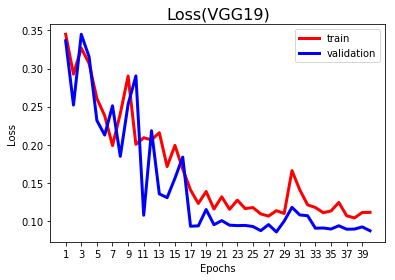

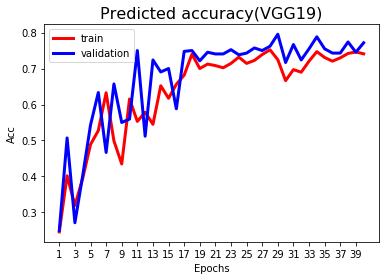

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

print('loss_train: ' + str(loss_train))
print('loss_val: ' + str(loss_val))
print('acc_train: ' + str(acc_train))
print('acc_val: ' + str(acc_val))

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss(VGG19)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy(VGG19)",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 41, 2.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='validation')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])
GroundTruth:     75    81    75    75
Predicted:     77    81    75    75


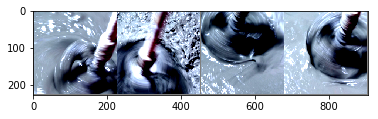

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['validation'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))

In [8]:
conc = {
    '0': '75  ',
    '1': '77  ',
    '2': '79  ',
    '3': '81  '
}

print("\t   Predicted\n")
print("\t   75\t77\t79\t81\n")
for i in range(0, num_classes):
    print("Actual ", end='')
    print(conc[str(i)], end='')
    for j in range(0, num_classes):
        print(str(best_matrix[i][j]) + '\t', end='')
    print('\n')

	   Predicted

	   75	77	79	81

Actual 75  44	58	1	2	

Actual 77  22	80	0	3	

Actual 79  0	0	105	0	

Actual 81  0	0	0	105	

